In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from igraph import Graph
import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    GRAPH = Graph.Read_Ncol(graph_path+str(file)+".txt", directed=False)
    nodes = [v.index for v in GRAPH.vs]
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(GRAPH)  
    Graph.simplify(GRAPH)
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = GraphGame
    env = Environment(game)
    attacker = DQN(state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    rewards, lcc, actions = EvaluateModel(env, attacker,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = GraphGame
    env = Environment(game)
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    '''game = GraphGame
    env = Environment(game)'''
    action_list = np.loadtxt(fname, dtype=int)
    rewards, lcc, actions = EvaluateACTION(action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix,title,plot_grid,grid): 
    if grid[0] * grid[1] < 10:
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(12, 10))
    else :
        figure, axis = plt.subplots(grid[0],grid[1],sharex=True,figsize=(22, 20))
    AUC  = []
    NodeRemoved = []
    model_name = ["MIX","BA","FINDER","CI","GDM","COREHD"]
    for i, graph_name in enumerate(file_list):
        print(graph_name, end =" ,")
        GRAPH, map = input_graph(graph_path,graph_name)
        N = GRAPH.vcount()
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        print(actions_mix)
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(actions_ba)

        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        rewards_Finder, lcc_Finder, actions_Finder = implement_Bench(fname,GRAPH.copy(),map)
        if (len(lcc_Finder) == 0):
            lcc_Finder = None
        print(actions_Finder)
        #Re Insert CI
        path = "./ReI_CI/"
        fname = path+graph_name+".txt"
        rewards_ReI_CI, lcc_ReI_CI, actions_ReI_CI = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_ReI_CI)
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions_CI = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_CI)
        
        #GDM
        path = "./GDM/"
        fname = path+graph_name+".txt"
        rewards_GDM, lcc_GDM, actions_GDM = implement_Bench(fname,GRAPH.copy(),map)
        print(actions_GDM)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions_CoreHD =  implement_Bench(fname,GRAPH.copy(),map)
        print(actions_CoreHD)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''

        x =  np.flip(np.arange(N+1)[N:0:-1]/N)

        #Plot LCC Decrease
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'Green',label='Trained Attacker')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'Red',label='Trained Attacker [BA model]')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'Aquamarine',label='FINDER ReTrained')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_GDM)],np.array(lcc_GDM)/N, 'Blue',label='GDM')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_ReI_CI)],np.array(lcc_ReI_CI)/N, 'Pink',label='ReI_CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'Orange',label='CI')
        axis[plot_grid[i][0],plot_grid[i][1]].plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'Brown',label='CoreHD')
        axis[plot_grid[i][0],plot_grid[i][1]].set_title(graph_name, fontdict={'fontsize': 18})
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_GDM = area_under_curve(x[:len(lcc_GDM)],lcc_GDM)
        auc_ReI_CI = area_under_curve(x[:len(lcc_ReI_CI)],lcc_ReI_CI)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_ReI_CI,auc_CI,auc_GDM,auc_CoreHD],dtype='O')
        
        actions_all = [actions_mix,actions_ba,actions_Finder,actions_ReI_CI,actions_CI,actions_GDM,actions_CoreHD]
        fractionNode = np.array([len(xi) for xi in actions_all],dtype='O')/N
        
        #Save it as a string array
        auc_idx = np.flatnonzero(np.array(auc_all,dtype='O') == np.array(auc_all,dtype='O').min()) # index of best auc
        fracNode_idx = np.flatnonzero(np.array(fractionNode ,dtype='O') == np.array(fractionNode ,dtype='O').min()) # index of best fraction_node
        auc_all= ["%.4f" % action for action in auc_all]
        fractionNode= ["%.3f" % action for action in fractionNode]
        for idx in auc_idx:
            auc_all[idx] = r"\cellcolor{blue!25}"+ auc_all[idx]
        for idx in fracNode_idx:
            fractionNode[idx] = r'\cellcolor{blue!25}'+ str(fractionNode[idx])
        AUC.append(np.insert(auc_all,0,graph_name.replace("_", " ")))
        NodeRemoved.append(np.insert(fractionNode,0,graph_name.replace("_", " ")))
    print()
    np.savetxt("./Figure/Compiled/AUC_"+title+".tex", AUC,delimiter=" & ",newline = "\\\\ \n", fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    np.savetxt("./Figure/Compiled/Removed_"+title+".tex", NodeRemoved,delimiter=" & ",newline = "\\\\ \n",fmt=('%s','%s','%s','%s','%s','%s','%s','%s')) 
    figure.text(0.5, 0.075,"Fraction of Nodes Removed" , fontsize = 18,  ha='center')
    figure.text(0.075, 0.5, "LCC/No. of Nodes", fontsize = 18,  va='center', rotation='vertical')
    #plt.title("LCC vs No. of Nodes for Agents")
    plt.savefig("./Figure/Compiled/"+title+".pdf")
    plt.show()


# Synthetic Network:

 ## BA GRAPH

barabasi_albert_30 ,[0, 3, 5, 6, 7, 2, 1, 23, 20, 25, 18, 19, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16]
[5, 8, 1, 7, 21, 3, 2, 6, 26, 14, 23, 0, 13, 16, 20, 18, 15]
[12, 0, 11, 6, 2, 3, 13, 7, 1, 14, 9, 18, 8, 10, 25, 22]
[12, 6, 7, 9, 13, 2, 3, 11, 1, 15, 18, 22, 20, 21, 16, 19, 27, 23, 26, 4, 5, 24, 29, 17, 28, 8, 25, 14, 10]
[0, 3, 6, 11, 7, 2, 12, 13, 1, 14, 8, 17, 5, 16, 19, 26, 27, 4, 15, 23, 18, 21, 24, 9, 10, 25, 22, 29, 20, 28]
[3, 0, 6, 5, 23, 8, 7, 2, 1, 25, 13, 21, 16, 22, 20, 4, 14, 24, 29, 9, 17, 28, 18, 15, 26, 27, 19, 11, 10, 12]
[0, 3, 26, 6, 27, 16, 7, 29, 11, 19, 1, 5, 23, 13, 10, 15, 28, 9, 2, 21, 25, 12, 24, 18, 17, 4, 8, 20, 22, 14]
barabasi_albert_50 ,[4, 27, 0, 1, 14, 8, 2, 28, 6, 3, 49, 5, 39, 16, 34, 29, 17, 41, 7, 9, 10, 11, 12, 13, 15, 18, 19, 20, 21, 22, 23, 24, 25, 26, 30, 31, 32, 33, 35]
[42, 10, 43, 32, 40, 7, 0, 27, 1, 30, 31, 3, 37, 41, 6, 2, 28, 47, 24, 5, 48, 21, 4, 39, 38, 11, 14, 8, 12, 20, 18, 13, 34]
[1, 6, 15, 8, 7, 2, 23, 5, 0, 4, 3, 10, 24, 19, 13,

[3, 0, 398, 1, 213, 284, 452, 323, 4, 300, 354, 7, 12, 378, 14, 15, 468, 8, 380, 30, 476, 59, 6, 424, 275, 290, 127, 23, 221, 328, 252, 26, 281, 2, 412, 28, 340, 414, 276, 388, 11, 348, 167, 18, 440, 369, 36, 255, 139, 185, 5, 337, 458, 457, 27, 212, 309, 58, 156, 218, 45, 418, 262, 76, 108, 409, 473, 306, 52, 80, 138, 38, 85, 372, 158, 83, 161, 56, 277, 410, 40, 499, 324, 376, 287, 50, 465, 432, 472, 74, 400, 246, 163, 51, 181, 41, 402, 453, 335, 9, 256, 21, 289, 264, 60, 435, 353, 171, 54, 295, 177, 429, 90, 456, 478, 113, 68, 186, 148, 170, 94, 16, 250, 151, 460, 135, 100, 303, 352, 320, 144, 206, 215, 293, 233, 132, 462, 17, 72, 416, 485, 13, 48, 479, 172, 142, 454, 480, 495, 147, 243, 491, 174, 116, 194, 236, 10, 428, 104, 443, 33, 375, 228, 367, 397, 210, 70, 329, 225, 261, 20, 444, 381, 145, 292, 62, 477, 187, 286, 129, 166, 44, 216, 291, 449, 374, 247, 173, 114, 241, 349, 461, 25, 149, 91, 283, 109, 159, 89, 204, 431, 121, 123, 268, 112, 438, 445, 370, 304, 430, 47, 157, 498, 3

[3, 10, 7, 12, 1, 4, 0, 9, 2, 18, 16, 19, 31, 28, 34, 48, 21, 70, 30, 17, 8, 107, 62, 127, 87, 14, 42, 6, 57, 54, 73, 23, 52, 160, 27, 35, 41, 95, 76, 103, 58, 172, 97, 98, 20, 5, 120, 118, 68, 164, 61, 22, 156, 29, 43, 55, 39, 46, 163, 123, 151, 90, 165, 75, 44, 248, 111, 252, 137, 96, 225, 484, 206, 407, 136, 13, 37, 157, 138, 11, 419, 56, 147, 80, 131, 69, 60, 104, 86, 324, 258, 182, 177, 255, 141, 229, 253, 122, 230, 83, 53, 354, 371, 105, 334, 310, 220, 420, 215, 81, 47, 320, 79, 145, 259, 333, 113, 219, 284, 525, 94, 188, 296, 88, 74, 326, 166, 451, 209, 116, 78, 72, 25, 45, 300, 144, 170, 280, 266, 228, 135, 494, 346, 340, 240, 428, 84, 198, 213, 638, 774, 224, 216, 153, 40, 187, 368, 475, 498, 146, 254, 636, 483, 501, 268, 26, 441, 221, 328, 880, 173, 888, 287, 365, 176, 249, 323, 51, 641, 643, 119, 203, 191, 548, 740, 192, 874, 398, 742, 657, 338, 92, 82, 400, 71, 480, 760, 390, 712, 361, 130, 204, 395, 283, 424, 313, 561, 565, 325, 811, 701, 263, 757, 50, 207, 503, 666, 692, 

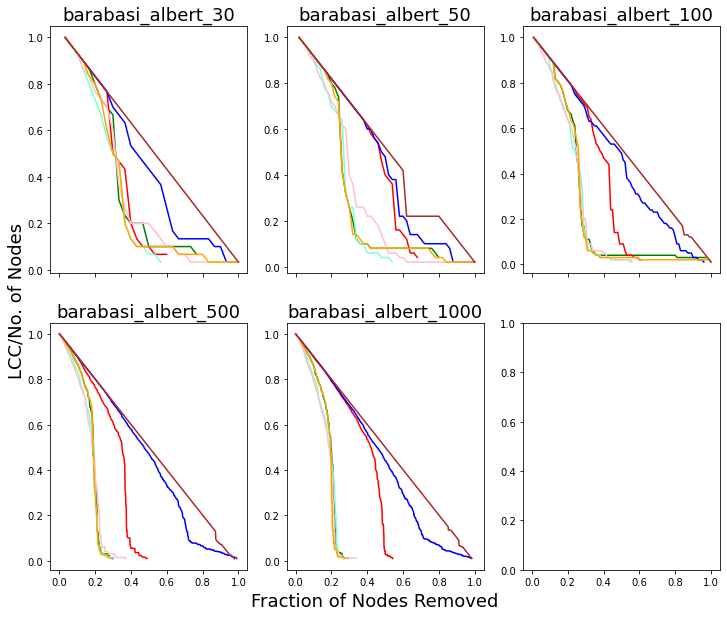

In [2]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['barabasi_albert_30','barabasi_albert_50','barabasi_albert_100','barabasi_albert_500','barabasi_albert_1000']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"ba",[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]],[2,3])


 ## ER GRAPH

erdos_renyi_30 ,[11, 14, 7, 23, 15, 21, 26, 3, 5, 25, 28, 10, 0, 1, 2, 4, 6, 8, 9, 12, 13, 16, 17, 27, 18]
[12, 11, 7, 23, 29, 15, 14, 21, 6, 2, 4, 20, 9, 19, 22]
[13, 23, 26, 14, 6, 12, 15, 22, 18, 17, 29, 19, 0, 1, 27, 25, 7]
[23, 13, 18, 14, 28, 6, 26, 29, 27, 12, 24, 1, 15, 21, 20, 10, 22, 3, 17, 16, 0, 25, 5, 19, 7, 2, 4, 11, 8]
[6, 12, 23, 14, 26, 15, 13, 1, 18, 27, 19, 0, 20, 11, 22, 2, 3, 4, 29, 5, 7, 8, 9, 28, 10, 16, 25, 17, 24, 21]
[7, 11, 14, 15, 23, 19, 20, 6, 12, 3, 4, 13, 26, 2, 21, 24, 28, 22, 10, 9, 29, 27, 16, 1, 17, 8, 0, 18, 25, 5]
[6, 12, 10, 23, 20, 9, 2, 4, 26, 7, 21, 28, 8, 22, 1, 24, 19, 25, 18, 14, 16, 13, 5, 11, 15, 29]
erdos_renyi_50 ,[46, 18, 29, 13, 10, 17, 9, 3, 27, 42, 30, 22, 5, 11, 15, 20, 4, 37, 36, 6, 2, 14, 16, 0, 33, 19, 1, 7, 8, 12, 21, 23, 24, 25, 26, 28, 31, 32, 34, 35]
[9, 18, 29, 11, 30, 32, 41, 27, 13, 35, 2, 21, 36, 7, 3, 5, 10, 14, 23, 37, 42, 4, 19, 6, 22, 15, 24, 0, 25, 1, 16, 12]
[27, 34, 24, 9, 4, 30, 13, 29, 42, 15, 7, 44, 6, 45, 33, 3

[229, 336, 116, 96, 199, 115, 197, 226, 422, 70, 66, 252, 326, 92, 236, 317, 71, 411, 357, 404, 370, 30, 15, 7, 61, 139, 26, 45, 487, 119, 124, 117, 44, 129, 283, 488, 389, 210, 201, 386, 19, 279, 220, 183, 402, 177, 103, 434, 344, 131, 297, 480, 246, 275, 466, 289, 52, 316, 381, 127, 441, 159, 164, 378, 264, 428, 51, 358, 133, 168, 351, 134, 491, 492, 14, 34, 170, 31, 383, 373, 120, 57, 306, 478, 285, 156, 17, 311, 49, 414, 46, 24, 455, 335, 207, 174, 171, 290, 477, 137, 40, 248, 328, 391, 324, 125, 146, 230, 485, 333, 84, 327, 36, 104, 157, 110, 320, 384, 0, 251, 107, 495, 366, 22, 185, 432, 228, 460, 332, 222, 121, 483, 74, 39, 278, 293, 319, 299, 343, 348, 175, 81, 493, 244, 153, 400, 176, 128, 458, 475, 151, 407, 292, 309, 437, 105, 423, 95, 462, 450, 16, 418, 32, 155, 55, 260, 361, 447, 350, 390, 443, 284, 372, 205, 341, 172, 72, 271, 239, 294, 435, 362, 364, 464, 8, 303, 256, 180, 436, 160, 100, 325, 148, 291, 353, 494, 53, 41, 135, 471, 216, 268, 97, 499, 227, 474, 287, 481, 88

[229, 116, 336, 197, 115, 422, 199, 70, 96, 66, 226, 252, 326, 92, 236, 317, 487, 370, 411, 357, 15, 404, 119, 7, 61, 26, 351, 45, 124, 129, 44, 389, 71, 210, 289, 283, 183, 168, 275, 488, 164, 402, 177, 220, 344, 30, 139, 386, 19, 297, 117, 264, 103, 127, 466, 52, 434, 378, 279, 316, 383, 358, 159, 491, 492, 32, 133, 428, 51, 441, 335, 480, 120, 414, 14, 373, 17, 34, 107, 476, 156, 285, 478, 381, 207, 36, 46, 84, 40, 146, 477, 171, 137, 24, 311, 324, 248, 125, 134, 153, 170, 131, 290, 455, 157, 391, 251, 230, 31, 97, 291, 174, 205, 485, 457, 493, 446, 88, 495, 418, 105, 320, 104, 135, 22, 436, 299, 499, 292, 222, 432, 327, 460, 458, 348, 284, 172, 228, 384, 333, 483, 39, 74, 121, 95, 343, 246, 55, 244, 319, 72, 151, 260, 303, 278, 185, 400, 437, 110, 232, 57, 293, 390, 41, 58, 353, 464, 364, 81, 443, 216, 53, 68, 294, 328, 49, 176, 471, 3, 8, 475, 0, 239, 100, 361, 148, 462, 128, 201, 407, 268, 372, 332, 309, 362, 415, 395, 256, 175, 243, 366, 253, 325, 196, 162, 482, 417, 341, 342, 4

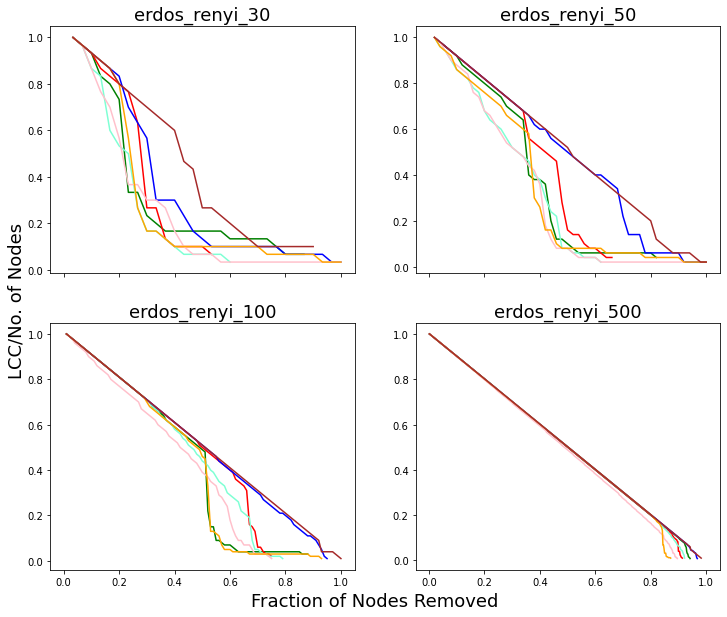

In [3]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['erdos_renyi_30','erdos_renyi_50','erdos_renyi_100','erdos_renyi_500']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"er",[[0,0],[0,1],[1,0],[1,1]],[2,2])


 ## SW GRAPH

small-world_30 ,[4, 20, 8, 24, 16, 3, 12, 19, 2, 25, 14, 1, 13, 5, 0, 15, 6, 7, 9, 10, 11, 17, 18, 21, 22]
[19, 4, 24, 2, 16, 26, 20, 3, 7, 13, 5, 8, 29, 15, 12, 23, 14]
[29, 26, 2, 8, 5, 24, 22, 10, 19, 15, 11, 17, 3, 28, 12, 23, 16, 4, 7, 21]
[5, 9, 8, 24, 25, 22, 12, 15, 19, 18, 11, 21, 3, 2, 29, 28, 26, 6, 10, 27, 1, 7, 14, 23, 17, 13, 16, 20, 4]
[8, 5, 19, 24, 15, 28, 10, 2, 25, 29, 11, 22, 3, 0, 1, 4, 6, 7, 14, 9, 12, 21, 13, 16, 17, 18, 20, 23, 26, 27]
[8, 4, 20, 19, 12, 17, 26, 0, 1, 24, 14, 2, 16, 13, 28, 15, 6, 3, 18, 9, 11, 7, 5, 22, 25, 29, 23, 27, 21, 10]
[19, 5, 15, 14, 16, 18, 17, 10, 24, 28, 2, 8, 0, 6, 7, 9, 4, 3, 1, 29, 27, 26, 25, 23, 13, 12, 11, 22, 21, 20]
small-world_50 ,[21, 35, 34, 38, 8, 11, 22, 30, 44, 3, 12, 26, 48, 36, 17, 46, 13, 0, 24, 37, 20, 33, 27, 1, 2, 4, 5, 15, 6, 28, 9, 7, 10, 14, 16, 18, 19, 23, 25, 29, 31, 32, 39, 40, 41]
[36, 12, 42, 26, 33, 11, 22, 43, 13, 16, 1, 38, 49, 8, 28, 47, 0, 20, 35, 31, 44, 3, 18, 34, 40, 6, 24, 17, 41, 27, 2, 29]
[7, 

[39, 79, 368, 170, 422, 243, 152, 430, 176, 165, 141, 126, 261, 240, 218, 356, 322, 32, 227, 178, 103, 203, 438, 130, 384, 64, 391, 172, 197, 231, 292, 189, 38, 34, 489, 389, 487, 344, 244, 22, 24, 27, 363, 52, 373, 56, 21, 41, 105, 26, 482, 133, 343, 181, 174, 217, 145, 125, 65, 251, 230, 260, 321, 199, 330, 367, 494, 479, 215, 202, 461, 163, 8, 101, 319, 67, 457, 297, 54, 286, 167, 311, 317, 2, 87, 90, 93, 345, 94, 30, 48, 355, 237, 377, 192, 188, 137, 18, 204, 211, 5, 429, 253, 254, 498, 486, 312, 302, 127, 164, 259, 442, 300, 160, 425, 102, 439, 394, 433, 233, 150, 285, 267, 314, 298, 360, 70, 60, 109, 305, 411, 412, 77, 332, 58, 421, 470, 146, 248, 291, 416, 472, 423, 476, 11, 120, 283, 441, 455, 177, 4, 59, 71, 73, 76, 107, 108, 115, 117, 118, 119, 182, 194, 279, 280, 282, 303, 304, 339, 397, 399, 400, 401, 402, 403, 409, 410, 413, 419, 35, 69, 169, 238, 274, 418, 471, 139, 49, 328, 364, 140, 156, 185, 273, 406, 249, 467, 436, 29, 83, 325, 463, 72, 74, 75, 110, 111, 112, 113, 114

[156, 137, 777, 27, 157, 629, 774, 988, 971, 633, 984, 307, 281, 809, 948, 771, 133, 972, 138, 160, 278, 141, 975, 161, 991, 968, 780, 626, 304, 30, 303, 643, 623, 77, 24, 275, 308, 282, 783, 31, 200, 34, 285, 164, 21, 978, 300, 311, 994, 947, 312, 583, 20, 361, 474, 18, 981, 165, 143, 286, 479, 426, 586, 364, 203, 944, 997, 579, 951, 37, 40, 576, 998, 582, 587, 952, 636, 206, 197, 943, 207, 5, 955, 196, 940, 526, 590, 1, 297, 574, 937, 147, 4, 571, 296, 593, 193, 958, 527, 6, 594, 936, 530, 620, 959, 192, 293, 146, 145, 43, 531, 597, 290, 189, 619, 44, 617, 962, 9, 670, 10, 291, 289, 614, 598, 188, 272, 258, 367, 365, 677, 185, 613, 184, 261, 370, 47, 601, 271, 255, 252, 180, 602, 66, 262, 48, 371, 640, 964, 168, 965, 637, 639, 644, 248, 967, 249, 374, 51, 800, 384, 52, 647, 799, 375, 245, 171, 797, 266, 269, 794, 715, 648, 378, 803, 244, 243, 172, 58, 379, 55, 848, 57, 240, 381, 651, 175, 806, 176, 480, 807, 392, 791, 652, 63, 483, 810, 62, 340, 181, 484, 788, 389, 67, 655, 813, 790,

[77, 200, 835, 538, 867, 947, 5, 207, 327, 281, 937, 978, 45, 747, 791, 83, 489, 190, 780, 875, 413, 864, 583, 934, 894, 116, 359, 211, 648, 432, 147, 315, 275, 714, 856, 414, 524, 525, 586, 584, 585, 266, 21, 67, 87, 579, 457, 814, 93, 80, 269, 267, 268, 444, 643, 697, 290, 101, 777, 778, 779, 776, 775, 597, 809, 547, 570, 655, 40, 850, 750, 888, 221, 486, 916, 258, 985, 659, 134, 879, 272, 270, 271, 794, 141, 859, 994, 273, 993, 274, 426, 322, 384, 304, 494, 800, 98, 706, 447, 718, 612, 10, 403, 160, 670, 202, 126, 225, 756, 754, 296, 906, 232, 964, 37, 39, 38, 910, 982, 372, 827, 214, 213, 215, 212, 111, 735, 785, 903, 871, 604, 895, 845, 34, 36, 35, 33, 108, 505, 499, 621, 528, 12, 930, 592, 958, 511, 11, 375, 388, 640, 481, 950, 441, 442, 443, 445, 446, 278, 277, 276, 279, 280, 761, 559, 913, 666, 27, 817, 352, 974, 434, 399, 398, 400, 401, 402, 484, 694, 361, 360, 25, 151, 153, 152, 392, 502, 501, 500, 771, 803, 681, 348, 703, 308, 768, 770, 769, 848, 846, 543, 299, 58, 464, 243,

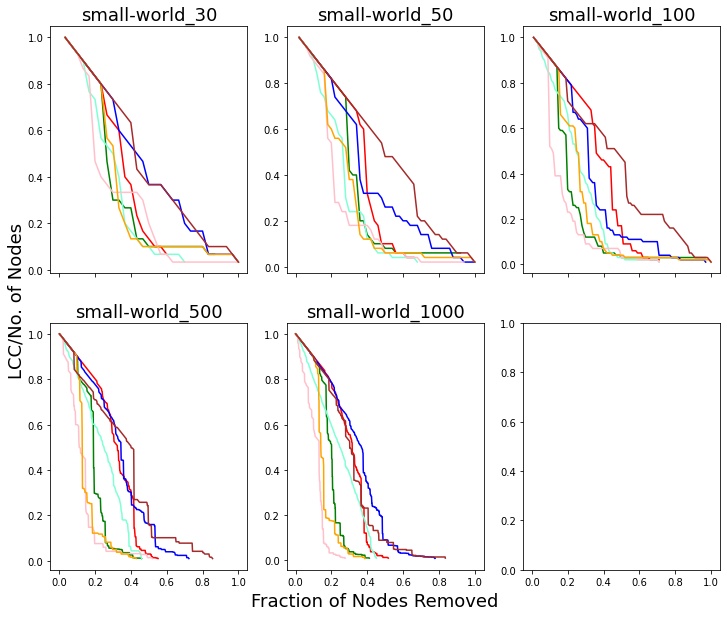

In [4]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
graph_path= "./Dataset/SyntheticGraph/"
file_list =  ['small-world_30','small-world_50','small-world_100','small-world_500','small-world_1000']
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"sw",[[0,0],[0,1],[0,2],[1,0],[1,1],[1,2]],[2,3])


# Synthetic with Motifs Attached

## BA

ba_300_20_house_1 ,[8, 6, 3, 10, 1, 7, 0, 42, 104, 9, 44, 2, 105, 5, 46, 103, 267, 107, 143, 85, 166, 108, 57, 12, 4, 294, 13, 51, 205, 193, 11, 219, 112, 119, 106, 110, 16, 248, 49, 218, 43, 52, 169, 303, 114, 164, 281, 60, 22, 56, 87, 54, 192, 61, 222, 288, 177, 275, 300, 86, 274, 245, 191, 14, 153, 50, 286, 252, 307, 58, 146, 97, 167, 63, 254, 59, 17, 260, 93, 189, 96, 95, 136, 53, 195, 173, 229, 122, 109, 156, 230, 236, 66, 210, 208, 175, 279, 145, 285, 249, 201, 324, 72, 76, 75, 325, 314, 309, 321, 71, 45, 157, 310, 322, 316, 115, 315, 237, 312, 69, 376, 160, 224, 111, 217, 272, 296, 302, 305, 308, 318, 319, 320, 15, 39, 28, 293, 90, 26, 20, 268, 127, 151, 181, 82, 94, 135, 240, 138, 142, 244, 258, 377]
[267, 12, 131, 225, 134, 124, 0, 104, 210, 8, 185, 90, 44, 42, 10, 278, 3, 30, 203, 263, 230, 182, 2, 56, 1, 143, 11, 222, 46, 106, 289, 94, 5, 107, 175, 258, 59, 264, 169, 51, 6, 19, 244, 148, 252, 213, 4, 57, 128, 145, 58, 268, 193, 85, 200, 20, 260, 18, 205, 201, 109, 243, 157, 

[52, 7, 125, 36, 8, 1, 123, 83, 45, 207, 202, 188, 219, 21, 238, 53, 124, 175, 73, 280, 169, 210, 122, 126, 85, 113, 4, 286, 90, 131, 194, 213, 216, 192, 15, 255, 25, 218, 179, 229, 211, 34, 208, 204, 9, 281, 0, 82, 174, 87, 235, 228, 155, 96, 6, 61, 3, 62, 106, 277, 150, 43, 14, 247, 5, 191, 182, 142, 289, 27, 246, 24, 170, 20, 279, 223, 54, 173, 260, 147, 23, 74, 10, 127, 212, 93, 176, 287, 300, 259, 189, 220, 272, 171, 152, 17, 239, 200, 50, 275, 290, 146, 102, 16, 79, 22, 297, 271, 18, 199, 158, 187, 222, 69, 26, 226, 263, 107, 293, 264, 28, 40, 273, 35, 145, 304, 148, 153, 237, 161, 265, 243, 136, 257, 234, 115, 56, 108, 233, 46, 55, 11, 236, 240, 38, 227, 156, 355, 120, 491, 86, 41, 72, 429, 105, 458, 97, 141, 232, 138, 404, 89, 44, 433, 164, 180, 307, 295, 362, 98, 484, 317, 320, 456, 117, 313, 492, 386, 101, 390, 462, 494, 249, 473, 2, 450, 480, 196, 477, 358, 408, 425, 193, 418, 422, 443, 469, 154, 435, 360, 482, 349, 353, 288, 294, 370, 374, 378, 382, 396, 440, 447, 454, 487,

ba_300_60_house_3 ,[6, 7, 2, 0, 8, 12, 4, 10, 1, 76, 20, 9, 11, 77, 14, 143, 56, 218, 118, 82, 58, 61, 26, 81, 183, 57, 84, 275, 17, 209, 19, 219, 156, 187, 13, 155, 129, 115, 79, 254, 90, 184, 18, 210, 308, 192, 88, 157, 78, 15, 152, 21, 273, 241, 85, 96, 64, 295, 232, 197, 119, 16, 246, 62, 265, 5, 35, 87, 54, 296, 163, 220, 291, 207, 117, 92, 259, 289, 225, 294, 191, 215, 65, 233, 284, 179, 248, 130, 356, 298, 211, 234, 107, 162, 28, 281, 135, 257, 270, 269, 128, 166, 159, 271, 343, 131, 121, 345, 193, 287, 327, 293, 594, 334, 436, 249, 319, 261, 307, 335, 561, 325, 337, 338, 348, 29, 323, 350, 69, 198, 358, 30, 364, 306, 360, 339, 349, 361, 194, 145, 329, 485, 142, 434, 222, 318, 322, 332, 359, 355, 357, 244, 140, 158, 457, 402, 367, 517, 494, 150, 379, 328, 303, 262, 230, 342, 394, 344, 387, 418, 473, 390, 398, 309, 422, 537, 426, 352, 430, 317, 330, 320, 59, 63, 448, 301, 137, 267, 264, 282, 540, 216, 487, 497]
[73, 66, 222, 19, 38, 35, 179, 327, 45, 298, 249, 121, 25, 210, 226, 

[6, 7, 2, 0, 8, 14, 4, 10, 1, 219, 9, 28, 12, 11, 92, 25, 17, 202, 21, 30, 117, 35, 39, 31, 159, 53, 70, 244, 44, 49, 13, 40, 69, 82, 26, 149, 73, 45, 63, 108, 171, 75, 47, 22, 186, 24, 79, 196, 15, 163, 90, 238, 262, 97, 188, 36, 289, 37, 261, 214, 247, 145, 157, 167, 33, 41, 224, 27, 20, 267, 104, 84, 88, 275, 52, 121, 113, 105, 264, 65, 23, 122, 146, 5, 98, 126, 50, 279, 278, 81, 168, 19, 213, 169, 147, 119, 142, 209, 139, 229, 269, 210, 232, 268, 112, 85, 291, 201, 237, 212, 46, 190, 272, 89, 103, 274, 136, 251, 205, 218, 135, 60, 155, 114, 106, 198, 560, 260, 563, 564, 561, 562, 116, 3, 64, 236, 138, 239, 42, 246, 250, 223, 216, 110, 94, 195, 16, 500, 200, 504, 503, 501, 502, 172, 243, 132, 29, 95, 140, 87, 133, 164, 277, 252, 137, 220, 43, 187, 266, 208, 197, 162, 540, 543, 240, 542, 18, 541, 544, 176, 276, 259, 48, 591, 592, 593, 580, 584, 280, 583, 72, 581, 582, 510, 514, 513, 512, 511, 285, 380, 383, 382, 384, 381, 595, 599, 596, 597, 598, 295, 96, 294, 293, 189, 545, 549, 245

[163, 141, 298, 142, 39, 38, 272, 24, 97, 46, 85, 79, 235, 374, 379, 384, 146, 211, 52, 27, 29, 260, 71, 247, 103, 98, 44, 302, 197, 72, 206, 181, 337, 237, 209, 198, 202, 367, 33, 241, 77, 26, 99, 297, 389, 100, 214, 189, 152, 101, 143, 380, 344, 226, 115, 193, 291, 50, 282, 80, 313, 240, 180, 212, 129, 128, 239, 96, 106, 144, 30, 49, 276, 222, 42, 94, 208, 21, 376, 300, 122, 199, 343, 176, 218, 360, 200, 184, 245, 140, 57, 322, 3, 288, 138, 28, 225, 292, 317, 286, 387, 227, 119, 290, 268, 285, 113, 224, 228, 261, 17, 31, 20, 90, 172, 131, 296, 372, 120, 139, 306, 4, 328, 74, 352, 191, 264, 160, 75, 217, 69, 281, 117, 294, 86, 109, 130, 70, 257, 370, 61, 48, 36, 359, 114, 104, 111, 81, 192, 213, 249, 342, 158, 82, 164, 229, 371, 25, 145, 16, 255, 265, 234, 223, 147, 275, 253, 310, 66, 259, 479, 693, 525, 580, 369, 47, 182, 64, 393, 405, 583, 238, 307, 87, 127, 600, 148, 258, 73, 156, 89, 151, 230, 165, 15, 83, 305, 23, 219, 256, 157, 243, 132, 690, 201, 207, 167, 14, 35, 413, 528, 551

[0, 6, 11, 7, 5, 10, 9, 8, 22, 15, 4, 18, 26, 60, 21, 23, 41, 675, 705, 370, 67, 760, 685, 530, 790, 785, 755, 735, 480, 775, 580, 585, 725, 750, 615, 635, 690, 595, 745, 640, 770, 535, 695, 720, 555, 765, 620, 670, 660, 780, 700, 490, 590, 650, 540, 645, 560, 440, 715, 405, 740, 610, 625, 435, 600, 360, 795, 350, 500, 415, 570, 445, 495, 655, 520, 510, 665, 410, 27, 475, 385, 340, 390, 420, 465, 305, 450, 355, 515, 380, 430, 375, 575, 455, 460, 525, 56, 99, 506, 631, 485, 680, 545, 505, 198, 605, 550, 425, 320, 470, 31, 183, 284, 551, 92, 395, 45, 33, 710, 365, 730, 115, 713, 565, 125, 566, 88, 52, 732, 310, 330, 326, 325, 335, 316, 336, 346, 300, 301, 345, 400, 401, 43, 73, 49, 101, 64, 110, 3, 93, 85, 76, 65, 59, 14, 47, 20, 244, 39, 120, 272, 219, 102, 34, 74, 207, 72, 68, 12, 218, 79, 91, 96, 35, 48, 132, 83, 100, 61, 28, 134, 2, 84, 78, 126, 107, 30, 165, 38, 32, 29, 209, 19, 119, 105, 190, 44, 117, 89, 130, 13, 71, 81, 293, 175, 114, 16, 90, 123, 172, 250, 178, 280, 24, 248, 191

ba_300_20_fan_1 ,[0, 6, 3, 7, 14, 66, 68, 1, 106, 105, 11, 10, 8, 9, 15, 24, 134, 5, 71, 12, 4, 152, 2, 67, 73, 145, 18, 70, 94, 22, 265, 69, 211, 13, 112, 156, 95, 109, 189, 17, 165, 153, 81, 295, 41, 23, 135, 29, 27, 39, 161, 125, 108, 143, 197, 282, 219, 232, 16, 160, 110, 32, 19, 230, 74, 149, 132, 239, 21, 288, 107, 88, 171, 87, 276, 100, 193, 293, 218, 159, 97, 208, 302, 289, 111, 280, 48, 191, 303, 258, 229, 144, 72, 163, 182, 96, 118, 38, 286, 256, 294, 176, 42, 186, 114, 260, 75, 85, 82, 307, 210, 36, 40, 254, 246, 155, 284, 259, 33, 141, 173, 283, 131, 223, 299, 318, 45, 101, 220, 30, 281, 226, 196, 169, 52, 194, 240, 296, 278, 184, 37, 140, 202, 84, 54, 126, 116, 309, 20, 28, 55, 62, 113, 123, 174, 192, 25, 26, 31, 34, 35, 43, 44, 46, 47, 49, 50, 51, 53, 56, 57, 58, 59, 60, 61, 63, 64, 65, 76, 77, 78, 79, 80, 83, 86, 89, 90, 91, 92, 93, 98, 99, 104, 115, 117, 119, 120, 121, 122, 124, 127, 128, 129, 130, 133, 136, 138, 139, 142, 146, 147, 148, 150, 151, 154, 157, 158, 162, 16

[220, 146, 64, 71, 333, 160, 45, 199, 270, 37, 95, 7, 314, 77, 90, 145, 10, 188, 229, 194, 2, 221, 195, 127, 74, 152, 105, 241, 148, 240, 242, 182, 213, 185, 131, 54, 84, 264, 211, 99, 31, 5, 223, 153, 191, 180, 176, 339, 0, 172, 263, 265, 96, 133, 72, 181, 18, 57, 19, 13, 56, 78, 3, 123, 155, 147, 303, 225, 11, 63, 6, 187, 166, 62, 190, 117, 174, 73, 230, 23, 34, 55, 112, 67, 79, 140, 60, 238, 12, 1, 259, 158, 178, 189, 193, 196, 165, 142, 136, 114, 280, 50, 29, 161, 159, 138, 9, 258, 61, 97, 76, 35, 80, 278, 137, 274, 184, 186, 85, 120, 260, 68, 134, 38, 297, 235, 110, 210, 202, 226, 183, 111, 179, 252, 69, 198, 156, 281, 212, 16, 282, 59, 27, 197, 192, 43, 313, 267, 206, 58, 177, 44, 141, 113, 200, 42, 208, 227, 244, 4, 171, 108, 151, 236, 47, 135, 119, 157, 205, 70, 299, 261, 8, 308, 228, 249, 251, 255, 106, 224, 272, 103, 91, 128, 26, 163, 39, 243, 15, 273, 81, 250, 291, 246, 143, 203, 17, 139, 315, 234, 266, 277, 83, 290, 305, 306, 298, 122, 256, 294, 107, 14, 87, 75, 254, 215, 2

[0, 6, 10, 16, 9, 21, 24, 7, 17, 15, 14, 13, 11, 8, 12, 18, 28, 20, 23, 33, 59, 41, 2, 47, 32, 70, 3, 25, 40, 1, 43, 52, 60, 58, 38, 57, 5, 144, 50, 133, 26, 120, 75, 54, 68, 164, 100, 77, 82, 61, 80, 81, 51, 19, 30, 46, 36, 86, 49, 130, 89, 205, 44, 62, 85, 105, 139, 135, 140, 69, 56, 151, 152, 87, 72, 74, 108, 253, 204, 290, 174, 71, 79, 145, 137, 173, 195, 35, 178, 196, 215, 67, 127, 136, 208, 186, 213, 34, 91, 132, 251, 223, 102, 125, 110, 63, 119, 175, 250, 128, 83, 118, 211, 150, 257, 295, 31, 76, 260, 148, 115, 177, 207, 180, 96, 37, 162, 288, 147, 259, 193, 210, 154, 272, 222, 107, 29, 146, 65, 124, 90, 73, 126, 202, 220, 122, 254, 55, 265, 39, 281, 97, 129, 282]
[29, 15, 188, 156, 187, 98, 111, 69, 17, 2, 71, 70, 5, 87, 57, 85, 143, 281, 21, 27, 201, 119, 127, 196, 1, 23, 211, 89, 31, 110, 26, 32, 11, 33, 109, 60, 186, 25, 90, 126, 74, 36, 262, 241, 304, 124, 155, 203, 14, 20, 3, 94, 193, 112, 18, 267, 76, 30, 282, 283, 8, 147, 220, 86, 128, 24, 12, 68, 77, 221, 55, 140, 141, 

[17, 265, 91, 23, 243, 130, 1, 19, 88, 246, 26, 98, 92, 110, 191, 14, 147, 207, 67, 68, 333, 20, 87, 165, 290, 131, 112, 331, 35, 119, 49, 86, 111, 319, 296, 15, 234, 193, 22, 138, 30, 3, 36, 89, 217, 10, 169, 161, 29, 185, 162, 85, 270, 349, 358, 170, 220, 172, 157, 4, 264, 43, 74, 11, 237, 55, 313, 25, 116, 70, 361, 320, 328, 39, 33, 76, 276, 351, 99, 340, 71, 379, 339, 95, 218, 28, 373, 124, 150, 194, 40, 133, 303, 308, 167, 144, 235, 42, 171, 283, 16, 282, 257, 53, 314, 56, 134, 69, 251, 139, 180, 221, 366, 188, 154, 78, 363, 32, 232, 357, 65, 228, 377, 348, 118, 127, 305, 360, 310, 94, 369, 45, 239, 200, 271, 160, 213, 242, 125, 31, 248, 120, 137, 201, 101, 212, 84, 326, 108, 159, 230, 173, 13, 204, 209, 301, 24, 286, 370, 345, 297, 166, 309, 252, 260, 140, 152, 164, 163, 177, 168, 57, 156, 261, 253, 54, 359, 38, 50, 222, 249, 231, 208, 73, 241, 52, 34, 250, 214, 210, 136, 285, 323, 113, 224, 263, 179, 192, 244, 122, 247, 132, 196, 356, 107, 62, 151, 21, 199, 115, 64, 186, 149, 14

[8, 0, 6, 10, 9, 14, 7, 12, 15, 16, 21, 13, 24, 22, 25, 139, 18, 36, 2, 30, 1, 17, 28, 20, 27, 56, 263, 38, 40, 291, 29, 26, 99, 5, 336, 32, 84, 72, 239, 88, 66, 254, 91, 176, 116, 249, 3, 110, 34, 79, 11, 173, 282, 37, 194, 242, 287, 39, 297, 70, 163, 298, 128, 50, 117, 197, 78, 202, 118, 98, 95, 63, 65, 241, 290, 90, 107, 52, 228, 100, 259, 148, 205, 77, 142, 96, 119, 147, 23, 41, 46, 85, 105, 114, 223, 288, 267, 238, 4, 189, 33, 252, 141, 101, 233, 92, 132, 146, 262, 215, 94, 221, 284, 157, 75, 149, 195, 102, 231, 126, 187, 203, 104, 265, 207, 289, 131, 247, 83, 210, 123, 270, 226, 82, 109, 232, 278, 158, 162, 269, 61, 150, 286, 235, 49, 121, 43, 371, 129, 106, 89, 273, 217, 214, 293, 264, 200, 199, 164, 285, 31, 170, 275, 35, 182, 191, 279, 258, 136, 188, 318, 54, 124, 153, 184, 58, 55, 76, 166, 161, 253, 122, 51, 256, 185, 69, 19, 133, 245, 180, 237, 73, 276, 113, 261, 212, 169, 125, 250, 64, 244, 93, 112, 87, 154, 179, 144, 152, 240, 225, 145, 227, 236, 60, 266, 71, 171, 190, 81,

ba_300_40_clique_2 ,[6, 7, 51, 0, 52, 50, 11, 9, 53, 2, 1, 14, 137, 4, 141, 114, 3, 12, 15, 10, 78, 55, 17, 8, 161, 226, 133, 102, 233, 18, 57, 16, 140, 240, 25, 116, 81, 274, 246, 160, 235, 192, 188, 58, 142, 56, 22, 101, 100, 293, 186, 61, 152, 135, 84, 147, 184, 28, 159, 232, 108, 213, 269, 190, 90, 291, 77, 162, 88, 134, 110, 244, 243, 287, 13, 167, 170, 278, 38, 59, 103, 111, 265, 34, 228, 115, 281, 275, 164, 158, 156, 238, 209, 271, 139, 214, 93, 85, 207, 23, 285, 288, 204, 83, 297, 29, 252, 210, 185, 227, 163, 79, 212, 177, 229, 44, 69, 21, 35, 91, 117, 268, 230, 286, 206, 136, 299, 187, 267, 298, 202, 236, 171, 37, 43, 279, 220, 193, 254, 86, 36, 225, 203, 218, 41, 89, 112, 191, 251, 26, 30, 45, 120, 123, 277, 5, 19, 20, 24, 27, 31, 32, 33, 39, 40, 42, 46, 47, 48, 49, 54, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 80, 82, 87, 92, 94, 95, 96, 97, 98, 99, 104, 105, 106, 107, 109, 113, 119, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 143, 144, 145, 146,

[37, 49, 163, 156, 143, 59, 38, 27, 296, 45, 9, 276, 51, 6, 236, 100, 160, 75, 30, 131, 34, 43, 78, 277, 11, 63, 46, 251, 20, 167, 185, 154, 12, 114, 8, 13, 153, 225, 117, 115, 272, 293, 136, 227, 48, 74, 201, 44, 76, 186, 213, 10, 238, 106, 5, 177, 29, 4, 233, 40, 239, 282, 41, 174, 159, 202, 166, 53, 203, 194, 232, 79, 223, 1, 60, 0, 264, 140, 139, 195, 281, 184, 187, 77, 165, 144, 269, 105, 24, 61, 126, 101, 134, 259, 92, 99, 73, 3, 196, 206, 35, 182, 286, 158, 146, 104, 298, 226, 135, 267, 80, 290, 243, 265, 179, 18, 247, 248, 275, 125, 191, 219, 215, 209, 96, 278, 175, 266, 2, 263, 260, 149, 56, 164, 62, 241, 261, 21, 169, 89, 237, 15, 103, 32, 192, 284, 242, 188, 55, 148, 129, 220, 93, 14, 95, 16, 155, 152, 91, 199, 108, 283, 274, 17, 52, 57, 157, 171, 249, 19, 7, 244, 84, 172, 180, 299, 170, 66, 90, 87, 86, 138, 132, 82, 198, 300, 124, 173, 178, 168, 294, 54, 39, 240, 268, 111, 224, 137, 36, 119, 42, 58, 64, 176]
[8, 10, 300, 12, 13, 0, 6, 4, 9, 18, 14, 7, 1, 25, 47, 70, 15, 27,

[300, 0, 2, 10, 7, 9, 6, 11, 16, 8, 14, 22, 4, 23, 39, 57, 20, 12, 21, 3, 45, 29, 1, 27, 50, 5, 26, 36, 59, 25, 33, 103, 28, 38, 37, 30, 54, 15, 55, 84, 81, 51, 52, 92, 47, 40, 95, 31, 24, 74, 102, 60, 210, 90, 120, 94, 178, 61, 100, 179, 88, 139, 181, 76, 13, 68, 240, 64, 86, 248, 115, 35, 164, 174, 19, 44, 209, 32, 91, 48, 143, 147, 127, 246, 212, 53, 156, 34, 132, 170, 213, 65, 163, 190, 71, 80, 73, 123, 118, 122, 144, 214, 87, 72, 96, 114, 250, 269, 131, 161, 236, 99, 205, 66, 206, 105, 232, 275, 187, 129, 17, 108, 43, 273, 49, 243, 18, 165, 265, 202, 194, 183, 70, 116, 157, 172, 279, 289, 238, 149, 152, 98, 113, 136, 168, 182, 201, 217, 222, 247, 263, 268, 287, 288, 291]
[254, 1, 115, 61, 126, 80, 18, 75, 16, 129, 5, 164, 11, 4, 142, 13, 128, 17, 185, 203, 252, 20, 81, 204, 76, 19, 143, 216, 118, 247, 166, 82, 10, 291, 3, 8, 26, 77, 30, 195, 92, 25, 228, 89, 127, 79, 84, 42, 21, 78, 233, 169, 276, 83, 299, 165, 158, 156, 236, 56, 88, 155, 23, 68, 27, 15, 235, 12, 241, 225, 32, 119

[300, 0, 6, 8, 4, 16, 7, 10, 12, 2, 22, 21, 14, 9, 18, 33, 25, 264, 19, 204, 20, 23, 277, 206, 226, 24, 3, 15, 98, 247, 233, 17, 29, 56, 69, 52, 60, 13, 34, 75, 49, 11, 39, 86, 176, 67, 70, 58, 83, 122, 185, 108, 76, 119, 68, 53, 103, 161, 196, 236, 91, 43, 110, 146, 44, 46, 55, 292, 199, 159, 72, 51, 125, 106, 31, 216, 145, 202, 155, 158, 214, 248, 26, 111, 82, 42, 294, 191, 37, 95, 254, 101, 148, 137, 274, 128, 130, 271, 61, 149, 131, 235, 182, 48, 88, 172, 65, 96, 278, 38, 73, 265, 94, 255, 169, 152, 27, 113, 280, 286, 59, 156, 283, 262, 171, 92, 168, 223, 201, 63, 138, 136, 290, 279, 57, 249, 132, 41, 213, 267, 144, 117, 84, 129, 242, 293, 112, 78, 143, 194, 97, 163, 297, 71, 80, 229, 32, 45, 221, 252, 259, 150, 79, 198, 81, 30, 109, 1, 270, 47, 188, 218, 50, 207, 257, 116, 157, 273, 177, 230, 284, 258, 164, 35, 222, 251, 275, 268, 74, 90, 85, 276, 192, 175, 93, 208, 296, 266, 250, 142, 260, 215, 219, 197, 299, 282, 240, 256, 126, 183, 134, 64, 28, 118, 193, 123, 127, 209, 190, 36,

[6, 2, 9, 0, 5, 20, 8, 29, 249, 11, 7, 10, 16, 22, 70, 44, 39, 13, 25, 60, 103, 32, 169, 36, 21, 18, 156, 31, 30, 1, 87, 12, 38, 79, 54, 57, 75, 77, 42, 159, 140, 64, 53, 149, 52, 46, 59, 121, 35, 266, 3, 124, 105, 19, 123, 227, 24, 254, 289, 74, 15, 50, 37, 104, 154, 26, 62, 165, 73, 163, 276, 17, 186, 191, 197, 106, 71, 275, 253, 288, 61, 68, 221, 138, 45, 211, 170, 43, 207, 41, 267, 84, 281, 212, 126, 144, 180, 260, 239, 157, 125, 226, 63, 113, 284, 241, 55, 179, 271, 4, 89, 258, 177, 261, 270, 112, 111, 192, 95, 230, 280, 402, 255, 34, 223, 158, 176, 209, 110, 127, 246, 208, 235, 153, 285, 291, 194, 100, 48, 161, 107, 47, 198, 233, 175, 399, 370, 234, 28, 94, 122, 273, 228, 264, 65, 206, 251, 152, 204, 201, 296, 93, 86, 298, 174, 348, 384, 360, 76, 189, 277, 229, 92, 243, 27, 336, 383, 72, 283, 354, 115, 178, 248, 220, 219, 193, 268, 390, 362, 322, 324, 316, 415, 413, 347, 377, 331, 82, 129, 257, 134, 217, 286, 203, 108, 185, 181, 237, 247, 147, 56, 150, 308, 326, 333, 323, 382, 41

[74, 362, 396, 406, 426, 441, 129, 31, 248, 378, 482, 485, 354, 356, 371, 375, 388, 394, 510, 428, 456, 501, 366, 407, 419, 427, 490, 516, 309, 451, 337, 175, 37, 148, 207, 126, 249, 27, 526, 124, 332, 21, 134, 193, 132, 28, 212, 229, 80, 20, 15, 469, 36, 38, 128, 149, 268, 528, 530, 384, 458, 471, 479, 524, 103, 185, 227, 357, 436, 515, 535, 81, 78, 88, 263, 184, 191, 336, 32, 107, 281, 280, 104, 95, 152, 333, 182, 79, 64, 130, 111, 109, 17, 253, 222, 242, 5, 267, 122, 168, 18, 23, 178, 156, 76, 90, 143, 314, 177, 123, 307, 53, 250, 190, 282, 77, 22, 87, 151, 19, 102, 44, 272, 225, 208, 29, 264, 304, 262, 481, 301, 290, 171, 187, 52, 343, 137, 317, 287, 295, 172, 138, 270, 392, 393, 402, 459, 463, 464, 466, 176, 203, 231, 260, 219, 245, 259, 150, 201, 276, 110, 237, 194, 404, 470, 518, 209, 240, 236, 96, 211, 94, 100, 157, 135, 39, 302, 238, 305, 83, 254, 221, 174, 277, 61, 217, 93, 3, 274, 210, 25, 169, 192, 202, 232, 158, 9, 155, 54, 230, 86, 162, 213, 116, 330, 24, 131, 59, 239, 24

[0, 5, 40, 95, 15, 17, 51, 47, 33, 24, 29, 45, 280, 64, 27, 75, 135, 190, 28, 2, 61, 14, 11, 41, 121, 8, 169, 206, 19, 9, 58, 167, 1, 195, 90, 12, 72, 57, 65, 156, 22, 113, 141, 36, 73, 158, 7, 23, 124, 88, 127, 105, 83, 16, 13, 35, 115, 86, 109, 20, 151, 107, 56, 50, 6, 43, 168, 49, 60, 81, 237, 68, 106, 100, 18, 21, 108, 215, 110, 131, 99, 55, 25, 10, 114, 120, 26, 79, 261, 48, 37, 44, 96, 4, 130, 155, 147, 139, 163, 119, 42, 102, 152, 242, 260, 162, 39, 38, 247, 89, 159, 154, 144, 254, 288, 164, 199, 244, 54, 570, 91, 138, 53, 267, 296, 118, 594, 590, 588, 589, 591, 492, 648, 650, 651, 649, 197, 69, 295, 279, 256, 272, 66, 136, 137, 203, 426, 428, 429, 427, 659, 658, 657, 655, 458, 456, 460, 461, 494, 496, 497, 265, 220, 165, 170, 189, 480, 468, 467, 463, 465, 466, 540, 450, 452, 451, 453, 445, 443, 441, 442, 439, 434, 435, 432, 433, 425, 419, 418, 417, 415, 407, 405, 406, 403, 395, 394, 393, 391, 552, 554, 557, 556, 303, 301, 305, 304, 365, 364, 363, 361, 359, 357, 358, 355, 353, 3

[25, 268, 38, 166, 187, 36, 115, 155, 14, 87, 183, 2, 69, 42, 223, 164, 167, 222, 16, 79, 103, 19, 75, 151, 10, 13, 248, 11, 147, 85, 153, 161, 120, 99, 165, 63, 168, 56, 12, 159, 162, 55, 109, 141, 106, 7, 94, 43, 157, 86, 6, 24, 51, 180, 227, 8, 37, 81, 0, 326, 110, 292, 121, 5, 76, 107, 9, 100, 88, 18, 372, 116, 15, 125, 288, 68, 192, 156, 65, 4, 138, 302, 263, 289, 145, 297, 254, 177, 124, 367, 295, 34, 225, 93, 23, 90, 281, 104, 207, 276, 235, 280, 31, 212, 269, 119, 206, 313, 256, 241, 251, 267, 39, 135, 91, 234, 35, 184, 146, 111, 203, 388, 95, 216, 321, 45, 114, 230, 142, 291, 247, 672, 62, 366, 266, 175, 32, 218, 21, 97, 474, 22, 204, 686, 391, 1, 397, 348, 445, 651, 332, 306, 514, 214, 642, 311, 738, 641, 373, 220, 609, 489, 20, 592, 661, 353, 387, 358, 375, 340, 364, 40, 336, 380, 635, 560, 341, 335, 384, 381, 228, 342, 331, 569, 389, 696, 339, 330, 328, 774, 484, 737, 499, 666, 243, 376, 58, 172, 213, 262, 274, 278, 287, 299, 301, 363, 310, 312, 314, 319, 322, 323, 327, 329

[6, 0, 7, 4, 18, 8, 27, 5, 22, 17, 52, 10, 11, 21, 51, 71, 15, 9, 33, 19, 28, 25, 48, 75, 26, 43, 37, 116, 38, 42, 232, 31, 72, 35, 50, 281, 137, 138, 36, 14, 92, 144, 30, 98, 143, 233, 49, 65, 126, 39, 2, 95, 96, 82, 182, 202, 107, 190, 93, 16, 108, 179, 165, 268, 97, 195, 101, 68, 221, 256, 278, 217, 136, 47, 133, 183, 53, 129, 264, 100, 270, 286, 76, 269, 60, 153, 1, 199, 243, 23, 194, 170, 13, 720, 189, 261, 241, 20, 122, 184, 180, 111, 226, 684, 624, 211, 215, 140, 159, 213, 275, 643, 69, 220, 102, 298, 252, 260, 66, 148, 124, 167, 205, 267, 546, 732, 191, 324, 104, 246, 285, 196, 41, 147, 756, 80, 115, 297, 564, 255, 274, 206, 258, 507, 768, 234, 489, 89, 708, 390, 599, 528, 130, 150, 67, 64, 227, 694, 468, 84, 348, 762, 231, 534, 696, 540, 120, 673, 280, 636, 160, 151, 456, 156, 306, 498, 474, 750, 582, 738, 519, 408, 54, 426, 63, 59, 174, 135, 744, 774, 414, 397, 714, 207, 249, 654, 177, 212, 288, 361, 367, 480, 510, 462, 702, 192, 55, 266, 378, 443, 602, 399, 770, 496, 566, 59

[0, 6, 9, 15, 10, 21, 1, 14, 17, 12, 13, 2, 3, 25, 11, 4, 8, 52, 61, 7, 39, 28, 5, 56, 18, 42, 29, 24, 58, 81, 35, 105, 95, 37, 77, 20, 22, 16, 27, 113, 23, 26, 49, 108, 208, 43, 107, 50, 85, 101, 137, 38, 51, 151, 78, 76, 31, 68, 45, 36, 40, 171, 33, 69, 145, 134, 60, 203, 67, 172, 93, 140, 30, 175, 92, 174, 87, 59, 94, 254, 116, 120, 96, 184, 66, 143, 65, 91, 162, 211, 82, 210, 193, 504, 255, 34, 150, 834, 84, 198, 606, 117, 861, 265, 115, 206, 237, 870, 132, 817, 32, 114, 635, 500, 740, 877, 426, 638, 402, 690, 169, 53, 780, 609, 612, 219, 222, 408, 582, 768, 888, 79, 736, 576, 828, 570, 622, 678, 301, 396, 414, 450, 345, 858, 480, 666, 444, 522, 810, 702, 714, 762, 792, 894, 798, 822, 840, 846, 558, 883, 864, 820, 588, 660, 672, 726, 786, 546, 552, 594, 636, 654, 684, 708, 750, 756, 804, 852, 176, 616, 498, 431, 306, 312, 318, 324, 330, 336, 348, 354, 360, 465, 366, 372, 378, 384, 390, 423, 432, 438, 456, 468, 474, 486, 492, 510, 516, 528, 538, 540, 564, 600, 624, 630, 642, 648, 69

ba_300_20_cycle_1 ,[43, 3, 143, 2, 111, 1, 44, 0, 6, 7, 9, 46, 10, 75, 8, 4, 50, 48, 180, 212, 242, 15, 110, 116, 11, 115, 146, 47, 122, 283, 78, 145, 53, 182, 52, 179, 12, 203, 184, 45, 79, 14, 114, 295, 118, 34, 163, 76, 144, 201, 49, 254, 17, 230, 181, 55, 217, 85, 92, 187, 31, 80, 84, 112, 274, 208, 235, 54, 157, 51, 243, 159, 221, 275, 171, 60, 234, 57, 94, 132, 88, 202, 279, 22, 67, 20, 256, 169, 272, 58, 226, 161, 102, 119, 63, 135, 59, 222, 304, 19, 134, 139, 26, 81, 93, 39, 219, 176, 183, 265, 124, 160, 95, 285, 72, 91, 16, 104, 137, 42, 5, 28, 338, 258, 284, 322, 140, 253, 291, 103, 225, 129, 125, 290, 136, 262, 228, 69, 178, 175, 197, 172, 66, 23, 214, 224, 229, 13, 70, 73, 74, 90, 105, 107, 113, 150, 204, 241, 301, 18, 21, 24, 25, 27, 29, 30, 32, 33, 35, 36, 37, 38, 40, 41, 56, 61, 62, 64, 65, 68, 71, 77, 82, 83, 86, 87, 96, 97, 98, 99, 100, 101, 106, 108, 109, 117, 120, 121, 123, 126, 128, 130, 131, 133, 138, 141, 142, 148, 149, 151, 152, 154, 155, 156, 158, 162, 164, 165,

[43, 263, 130, 17, 292, 117, 248, 124, 48, 72, 247, 18, 136, 7, 351, 128, 196, 206, 161, 201, 108, 198, 8, 63, 107, 220, 2, 80, 213, 10, 38, 134, 14, 142, 95, 53, 236, 52, 256, 126, 60, 135, 33, 0, 131, 81, 133, 132, 110, 113, 12, 5, 32, 204, 334, 77, 150, 320, 229, 253, 6, 94, 55, 177, 78, 171, 3, 164, 47, 62, 165, 216, 109, 270, 59, 21, 79, 138, 26, 13, 121, 203, 70, 68, 232, 197, 83, 231, 9, 156, 282, 308, 16, 93, 115, 273, 186, 237, 36, 187, 257, 174, 230, 147, 96, 37, 244, 240, 157, 283, 27, 192, 272, 180, 254, 22, 242, 172, 114, 127, 56, 11, 111, 25, 182, 97, 208, 120, 129, 166, 145, 112, 51, 54, 146, 235, 123, 207, 153, 300, 148, 189, 169, 85, 74, 181, 269, 209, 291, 155, 118, 194, 191, 154, 44, 227, 90, 4, 324, 281, 299, 149, 199, 139, 228, 152, 167, 122, 193, 252, 288, 144, 280, 348, 302, 82, 264, 184, 323, 84, 64, 330, 29, 255, 266, 249, 42, 265, 99, 61, 331, 88, 289, 35, 39, 141, 336, 343, 125, 233, 76, 140, 340, 243, 190, 338, 137, 352, 278, 49, 205, 274, 217, 69, 259, 261,

[70, 50, 20, 13, 15, 65, 61, 0, 9, 7, 8, 27, 3, 12, 60, 25, 48, 32, 250, 100, 53, 115, 40, 210, 46, 6, 63, 109, 149, 21, 44, 201, 26, 47, 11, 58, 73, 170, 219, 225, 16, 14, 28, 135, 140, 1, 206, 10, 2, 111, 125, 19, 22, 45, 255, 131, 107, 144, 272, 71, 156, 34, 273, 129, 169, 218, 39, 95, 130, 110, 192, 226, 105, 31, 97, 103, 191, 164, 52, 119, 76, 128, 243, 176, 36, 202, 251, 72, 23, 108, 162, 84, 88, 75, 165, 18, 180, 177, 258, 182, 17, 85, 41, 43, 37, 159, 81, 209, 93, 4, 290, 314, 55, 134, 87, 57, 256, 155, 54, 133, 82, 188, 370, 406, 68, 148, 215, 96, 91, 208, 161, 194, 160, 158, 126, 212, 117, 418, 80, 24, 30, 195, 264, 377, 104, 270, 337, 398, 382, 414, 67, 400, 394, 412, 152, 392, 367, 141, 132, 221, 261, 360, 374, 239, 336, 183, 388, 415, 139, 404, 376, 262, 29, 232, 200, 407, 302, 279, 396]
[0, 9, 10, 12, 2, 7, 16, 6, 15, 26, 21, 13, 11, 19, 31, 3, 48, 18, 20, 47, 46, 70, 14, 32, 8, 34, 17, 27, 1, 22, 71, 58, 65, 45, 44, 23, 107, 61, 50, 24, 60, 176, 88, 250, 75, 84, 149, 25,

[42, 30, 66, 84, 15, 24, 75, 54, 48, 44, 122, 35, 17, 9, 8, 39, 222, 102, 106, 0, 6, 4, 10, 13, 45, 20, 14, 22, 5, 2, 74, 79, 21, 43, 69, 7, 139, 129, 47, 57, 53, 55, 176, 177, 131, 138, 120, 215, 11, 105, 28, 128, 202, 65, 40, 18, 49, 32, 29, 3, 26, 87, 204, 228, 82, 58, 130, 135, 239, 16, 34, 133, 36, 92, 19, 95, 201, 132, 113, 114, 226, 38, 247, 12, 51, 83, 50, 147, 136, 46, 61, 108, 209, 144, 41, 236, 111, 52, 103, 23, 63, 90, 175, 25, 187, 37, 184, 168, 192, 210, 62, 33, 127, 123, 207, 86, 124, 68, 174, 155, 198, 110, 116, 60, 171, 191, 164, 420, 194, 275, 283, 31, 67, 119, 153, 284, 78, 233, 163, 71, 214, 27, 88, 234, 444, 289, 77, 340, 369, 291, 270, 278, 299, 76, 364, 186, 410, 293, 183, 264, 454, 126, 378, 348, 426, 412, 195, 427, 379, 381, 354, 406, 398, 321, 250, 255, 442, 112, 232, 423, 408, 248, 149, 434, 223, 404, 450, 99, 221]
[0, 8, 2, 14, 20, 9, 17, 7, 16, 4, 25, 10, 35, 5, 13, 28, 6, 49, 53, 54, 42, 22, 120, 24, 47, 21, 15, 29, 30, 40, 45, 12, 26, 3, 57, 50, 75, 66, 1

[6, 0, 7, 9, 5, 14, 10, 3, 24, 15, 1, 22, 4, 38, 17, 23, 13, 32, 52, 62, 19, 8, 35, 16, 55, 67, 45, 11, 66, 41, 42, 56, 20, 78, 31, 53, 21, 29, 61, 188, 28, 54, 30, 100, 123, 91, 80, 90, 144, 87, 108, 150, 166, 88, 209, 46, 37, 18, 33, 184, 60, 159, 121, 249, 148, 57, 217, 12, 112, 200, 44, 65, 84, 103, 93, 73, 27, 140, 47, 252, 126, 69, 96, 155, 59, 260, 50, 177, 34, 119, 152, 190, 168, 255, 118, 2, 238, 43, 214, 163, 164, 225, 267, 138, 127, 130, 293, 48, 106, 81, 116, 251, 124, 110, 180, 234, 245, 192, 171, 213, 99, 76, 151, 97, 63, 257, 89, 82, 143, 244, 120, 199, 135, 296, 195, 169, 270, 219, 25, 26, 104, 239, 285, 40, 117, 176, 142, 178, 72, 146, 186, 288, 132, 36, 49, 51, 71, 79, 113, 125, 131, 236, 259, 265, 276, 289, 290, 300, 68, 83, 134, 153, 173, 203, 210, 215, 218, 107, 261, 115, 122, 136, 149, 179, 194, 212, 221, 223, 228, 235, 271, 297, 161, 167, 187, 246, 253, 268, 280, 95, 191, 241, 269, 74, 86, 92, 114, 137, 147, 162, 183, 220]
[62, 212, 20, 65, 104, 11, 140, 63, 122,

[112, 75, 244, 91, 14, 159, 78, 1, 126, 234, 95, 46, 97, 227, 249, 79, 15, 205, 104, 28, 131, 17, 94, 3, 207, 26, 5, 317, 127, 72, 18, 178, 92, 134, 71, 262, 9, 98, 16, 184, 339, 192, 182, 179, 165, 96, 161, 132, 157, 32, 315, 21, 83, 47, 276, 93, 338, 146, 277, 166, 31, 329, 254, 235, 160, 206, 19, 306, 67, 314, 139, 107, 302, 209, 29, 99, 4, 260, 167, 213, 211, 147, 210, 250, 313, 87, 33, 331, 73, 291, 208, 140, 222, 30, 142, 186, 12, 2, 100, 149, 247, 44, 158, 245, 200, 191, 177, 273, 68, 290, 239, 65, 272, 185, 125, 45, 27, 22, 152, 133, 274, 180, 281, 77, 330, 337, 252, 80, 130, 325, 287, 13, 271, 219, 171, 183, 296, 308, 129, 84, 237, 319, 189, 292, 52, 88, 20, 229, 64, 117, 55, 285, 259, 218, 143, 217, 114, 204, 135, 240, 35, 261, 63, 238, 228, 25, 223, 66, 269, 163, 85, 236, 60, 216, 195, 241, 51, 248, 34, 42, 111, 43, 193, 194, 176, 53, 264, 151, 113, 253, 242, 106, 37, 198, 300, 224, 283, 214, 299, 196, 168, 170, 154, 174, 280, 164, 62, 162, 38, 128, 124, 116, 232, 226, 148, 

[32, 72, 78, 26, 214, 181, 205, 34, 160, 260, 12, 152, 218, 168, 180, 348, 105, 103, 16, 133, 234, 224, 73, 267, 33, 98, 25, 11, 129, 186, 127, 179, 80, 204, 76, 188, 132, 100, 37, 156, 130, 172, 146, 87, 231, 23, 248, 125, 22, 357, 151, 15, 14, 134, 286, 74, 7, 108, 149, 83, 44, 17, 229, 206, 81, 250, 261, 170, 30, 45, 237, 178, 101, 86, 121, 24, 219, 158, 140, 303, 82, 332, 358, 280, 226, 4, 124, 189, 331, 77, 150, 215, 84, 300, 157, 155, 290, 171, 339, 334, 50, 323, 42, 91, 63, 185, 47, 251, 202, 49, 207, 147, 99, 197, 2, 291, 276, 328, 351, 200, 277, 68, 345, 356, 352, 183, 173, 131, 236, 335, 249, 198, 241, 281, 111, 203, 275, 193, 123, 263, 177, 109, 292, 36, 19, 253, 52, 169, 306, 313, 256, 43, 62, 27, 343, 182, 89, 10, 75, 326, 58, 324, 29, 216, 154, 239, 293, 175, 141, 232, 225, 227, 333, 310, 48, 107, 59, 128, 278, 53, 117, 217, 220, 257, 60, 79, 221, 135, 315, 13, 271, 153, 94, 164, 243, 41, 139, 5, 223, 245, 20, 115, 269, 21, 162, 174, 190, 144, 166, 244, 85, 9, 35, 208, 3,

[8, 0, 5, 6, 9, 10, 20, 13, 4, 26, 168, 2, 28, 1, 12, 62, 27, 44, 42, 41, 320, 7, 25, 32, 123, 36, 52, 209, 48, 21, 19, 65, 17, 31, 14, 55, 223, 98, 88, 3, 82, 145, 108, 112, 125, 16, 295, 50, 281, 57, 38, 53, 121, 269, 67, 115, 160, 323, 11, 18, 111, 179, 58, 106, 189, 69, 76, 167, 74, 196, 164, 40, 294, 265, 33, 283, 148, 138, 203, 346, 39, 146, 174, 23, 351, 35, 185, 261, 68, 47, 54, 199, 152, 256, 222, 49, 274, 175, 226, 43, 188, 131, 61, 154, 264, 266, 271, 141, 250, 237, 162, 377, 231, 129, 343, 251, 255, 56, 158, 177, 227, 378, 86, 297, 178, 262, 116, 280, 34, 109, 260, 187, 126, 286, 22, 143, 119, 91, 239, 46, 198, 113, 173, 176, 140, 268, 216, 153, 210, 299, 276, 118, 254, 279, 166, 15, 133, 194, 267, 94, 183, 60, 45, 275, 291, 77, 101, 207, 81, 290, 84, 225, 144, 181, 51, 100, 270, 245, 102, 248, 213, 90, 180, 219, 221, 151, 205, 92, 224, 117, 272, 159, 263, 214, 110, 252, 285, 150, 73, 170, 282, 171, 120, 127, 233, 288, 78, 289, 30, 134, 238, 99, 243, 70, 89, 253, 278, 184, 

ba_300_20_grid_1 ,[4, 10, 0, 1, 15, 9, 8, 101, 6, 153, 129, 12, 104, 7, 13, 85, 57, 170, 19, 52, 50, 14, 155, 105, 168, 102, 276, 59, 235, 169, 156, 154, 17, 106, 205, 2, 53, 111, 131, 68, 172, 88, 56, 143, 130, 220, 239, 11, 22, 96, 58, 171, 243, 112, 51, 87, 33, 18, 62, 145, 158, 21, 245, 142, 290, 246, 141, 140, 230, 266, 86, 110, 279, 249, 54, 76, 3, 32, 114, 258, 209, 277, 64, 36, 159, 211, 66, 264, 113, 30, 283, 107, 192, 117, 291, 189, 257, 320, 286, 262, 449, 315, 332, 184, 318, 298, 35, 280, 267, 389, 328, 412, 427, 452, 359, 460, 343, 201, 351, 367, 375, 420, 435, 443, 468, 404, 16, 231, 128, 270, 148, 273, 394, 310, 26, 221, 70, 473, 271, 55, 339, 122, 177, 281, 300, 316, 133, 260, 322, 312, 293, 137, 278, 146, 323, 381, 397, 476, 301, 334, 161, 194, 215, 302, 247, 84, 292, 307, 309, 313, 317, 319, 321, 49, 348, 356, 364, 372, 380, 187, 213, 409, 44, 95, 206, 23, 417, 424, 432, 440, 448, 457, 465, 469, 178, 61, 42, 119, 224, 275, 25, 38, 288, 81, 144, 162, 179, 181, 182, 198

[4, 10, 0, 1, 9, 18, 8, 6, 23, 26, 21, 12, 7, 31, 14, 211, 33, 40, 52, 238, 17, 41, 282, 187, 16, 27, 32, 13, 113, 37, 36, 25, 45, 35, 126, 49, 5, 117, 144, 73, 233, 28, 34, 39, 2, 205, 56, 85, 92, 273, 106, 227, 44, 298, 46, 66, 249, 53, 89, 65, 261, 114, 253, 54, 275, 95, 70, 207, 11, 118, 250, 115, 184, 43, 58, 161, 123, 172, 278, 55, 134, 132, 146, 176, 214, 255, 15, 281, 29, 257, 71, 50, 63, 190, 72, 208, 185, 38, 151, 294, 86, 268, 61, 108, 100, 90, 213, 210, 124, 20, 129, 125, 42, 47, 297, 136, 76, 64, 216, 152, 170, 237, 78, 182, 215, 3, 292, 271, 265, 79, 101, 209, 91, 84, 109, 174, 80, 245, 228, 137, 231, 226, 22, 96, 138, 286, 202, 212, 178, 143, 149, 246, 122, 156, 272, 269, 75, 254, 289, 82, 256, 107, 130, 67, 241, 19, 283, 74, 223, 219, 111, 173, 104, 220, 181, 224, 169, 299, 284, 274, 180, 163, 177, 81, 141, 88, 295, 385, 201, 140, 145, 221, 260, 155, 162, 119, 196, 164, 466, 366, 369, 430, 349, 133, 147, 280, 99, 340, 475, 236, 112, 267, 243, 194, 168, 304, 376, 439, 17

[30, 229, 224, 202, 131, 162, 90, 199, 272, 181, 166, 124, 190, 23, 213, 137, 134, 104, 76, 102, 28, 89, 120, 95, 274, 232, 25, 240, 286, 295, 123, 163, 328, 242, 147, 182, 43, 281, 91, 57, 258, 135, 209, 39, 132, 261, 255, 77, 24, 17, 285, 247, 167, 262, 215, 14, 233, 246, 56, 263, 253, 221, 198, 133, 21, 101, 228, 31, 55, 88, 344, 191, 217, 122, 80, 300, 251, 248, 15, 164, 201, 38, 114, 82, 141, 225, 29, 280, 73, 235, 68, 145, 103, 256, 189, 170, 297, 63, 118, 277, 214, 100, 34, 216, 65, 318, 194, 165, 227, 60, 343, 26, 22, 169, 47, 130, 335, 81, 66, 204, 37, 150, 333, 78, 2, 303, 283, 327, 110, 149, 156, 155, 307, 193, 299, 138, 94, 54, 250, 126, 276, 301, 338, 324, 35, 197, 176, 143, 128, 278, 218, 61, 220, 116, 208, 311, 129, 121, 271, 105, 168, 264, 75, 79, 252, 173, 257, 161, 282, 245, 41, 112, 265, 99, 113, 85, 289, 140, 19, 42, 269, 18, 62, 87, 259, 58, 27, 157, 136, 74, 72, 13, 239, 195, 84, 268, 360, 615, 398, 154, 591, 293, 158, 5, 125, 270, 260, 59, 382, 200, 93, 294, 70, 

[0, 7, 6, 10, 3, 2, 12, 9, 16, 5, 4, 24, 15, 17, 8, 25, 67, 23, 11, 34, 14, 206, 30, 21, 754, 367, 475, 592, 376, 340, 322, 304, 336, 40, 372, 363, 588, 331, 20, 750, 103, 471, 72, 583, 727, 709, 682, 556, 723, 705, 552, 678, 579, 45, 808, 412, 408, 385, 493, 529, 403, 790, 466, 547, 90, 525, 489, 399, 55, 543, 786, 462, 628, 637, 655, 394, 502, 358, 781, 421, 390, 624, 498, 777, 633, 651, 417, 354, 511, 745, 457, 601, 430, 646, 349, 439, 642, 597, 453, 507, 165, 435, 484, 691, 480, 100, 687, 574, 799, 826, 763, 736, 822, 795, 570, 42, 732, 759, 835, 313, 831, 179, 49, 718, 205, 804, 565, 700, 561, 696, 673, 664, 772, 817, 448, 159, 200, 677, 660, 662, 768, 541, 813, 444, 610, 619, 234, 717, 714, 39, 314, 53, 606, 615, 520, 227, 253, 534, 175, 345, 516, 138, 56, 19, 51, 13, 27, 190, 59, 211, 38, 139, 87, 29, 79, 31, 135, 52, 127, 33, 198, 22, 142, 80, 137, 113, 37, 71, 108, 63, 102, 28, 1, 50, 77, 214, 60, 184, 101, 193, 111, 43, 109, 188, 286, 231, 41, 181, 73, 76, 85, 164, 128, 26, 1

ba_300_80_grid_4 ,[6, 257, 166, 112, 1, 60, 209, 71, 240, 126, 229, 197, 7, 8, 121, 0, 120, 49, 9, 2, 10, 55, 14, 101, 50, 3, 51, 13, 269, 102, 52, 212, 133, 122, 215, 173, 5, 23, 143, 48, 11, 12, 223, 64, 188, 56, 254, 98, 259, 136, 104, 185, 271, 211, 103, 27, 63, 17, 187, 148, 21, 278, 26, 22, 274, 177, 119, 147, 132, 172, 149, 280, 174, 62, 24, 189, 150, 16, 266, 18, 252, 204, 191, 186, 130, 255, 152, 74, 311, 290, 243, 36, 25, 235, 221, 251, 184, 175, 164, 225, 214, 237, 20, 15, 85, 780, 68, 437, 125, 92, 808, 428, 306, 93, 717, 82, 339, 19, 124, 498, 418, 362, 765, 529, 909, 140, 517, 282, 144, 654, 376, 326, 109, 974, 378, 352, 391, 664, 882, 811, 898, 631, 998, 952, 472, 1006, 688, 154, 704, 851, 866, 576, 712, 608, 752, 759, 890, 835, 488, 982, 874, 536, 990, 819, 827, 495, 744, 796, 858, 922, 960, 310, 387, 400, 414, 431, 440, 448, 456, 464, 480, 504, 544, 552, 560, 568, 584, 592, 600, 623, 639, 647, 672, 680, 696, 720, 728, 736, 843, 906, 937, 944, 1014, 371, 4, 324, 34, 61,

[6, 9, 1, 0, 36, 18, 7, 10, 2, 227, 15, 260, 11, 19, 34, 14, 22, 21, 17, 29, 131, 37, 16, 92, 45, 70, 23, 3, 28, 12, 80, 63, 83, 47, 33, 74, 13, 62, 108, 167, 5, 66, 101, 43, 27, 72, 147, 195, 152, 172, 25, 93, 257, 271, 87, 59, 24, 114, 264, 77, 151, 48, 125, 120, 65, 209, 276, 44, 26, 46, 258, 67, 230, 126, 216, 85, 91, 239, 35, 82, 255, 194, 51, 262, 181, 170, 265, 129, 273, 291, 32, 259, 75, 282, 203, 102, 182, 145, 124, 235, 56, 187, 40, 55, 160, 196, 190, 154, 78, 284, 176, 60, 149, 177, 214, 236, 247, 210, 95, 42, 201, 99, 179, 134, 105, 127, 73, 223, 245, 153, 100, 104, 107, 113, 61, 50, 64, 269, 84, 274, 139, 94, 199, 68, 128, 184, 173, 233, 226, 246, 289, 292, 86, 49, 136, 279, 116, 166, 736, 186, 280, 191, 287, 283, 178, 772, 556, 745, 118, 243, 270, 41, 103, 288, 133, 322, 169, 439, 376, 547, 466, 200, 164, 142, 137, 98, 238, 231, 340, 237, 248, 278, 110, 218, 221, 293, 140, 933, 936, 930, 529, 673, 331, 925, 889, 943, 358, 403, 349, 79, 754, 367, 619, 475, 122, 132, 165, 8

[6, 8, 7, 15, 9, 0, 21, 17, 10, 41, 25, 11, 46, 4, 27, 13, 18, 5, 66, 20, 12, 34, 14, 3, 36, 93, 78, 26, 39, 75, 32, 52, 19, 35, 68, 24, 77, 97, 45, 30, 54, 84, 22, 143, 111, 120, 49, 67, 23, 64, 128, 99, 124, 86, 125, 48, 28, 44, 96, 119, 42, 151, 105, 87, 50, 140, 206, 121, 162, 180, 183, 161, 69, 98, 51, 138, 101, 170, 81, 31, 197, 83, 243, 38, 130, 150, 137, 141, 253, 147, 135, 122, 156, 231, 73, 117, 625, 179, 240, 53, 57, 186, 195, 148, 110, 219, 103, 144, 273, 607, 1141, 91, 427, 404, 910, 892, 296, 90, 382, 539, 919, 192, 712, 816, 484, 634, 962, 207, 200, 189, 288, 249, 1060, 177, 502, 1015, 225, 768, 786, 952, 56, 340, 691, 808, 898, 1069, 1078, 1096, 493, 520, 682, 700, 763, 781, 1006, 1042, 1105, 1114, 1132, 1150, 1159, 1186, 1195, 160, 646, 655, 673, 799, 826, 934, 943, 970, 988, 1087, 1177, 304, 313, 322, 331, 349, 358, 367, 376, 394, 412, 421, 439, 448, 457, 466, 475, 1138, 511, 529, 547, 556, 565, 574, 583, 592, 601, 619, 664, 718, 727, 736, 745, 754, 835, 844, 853, 862

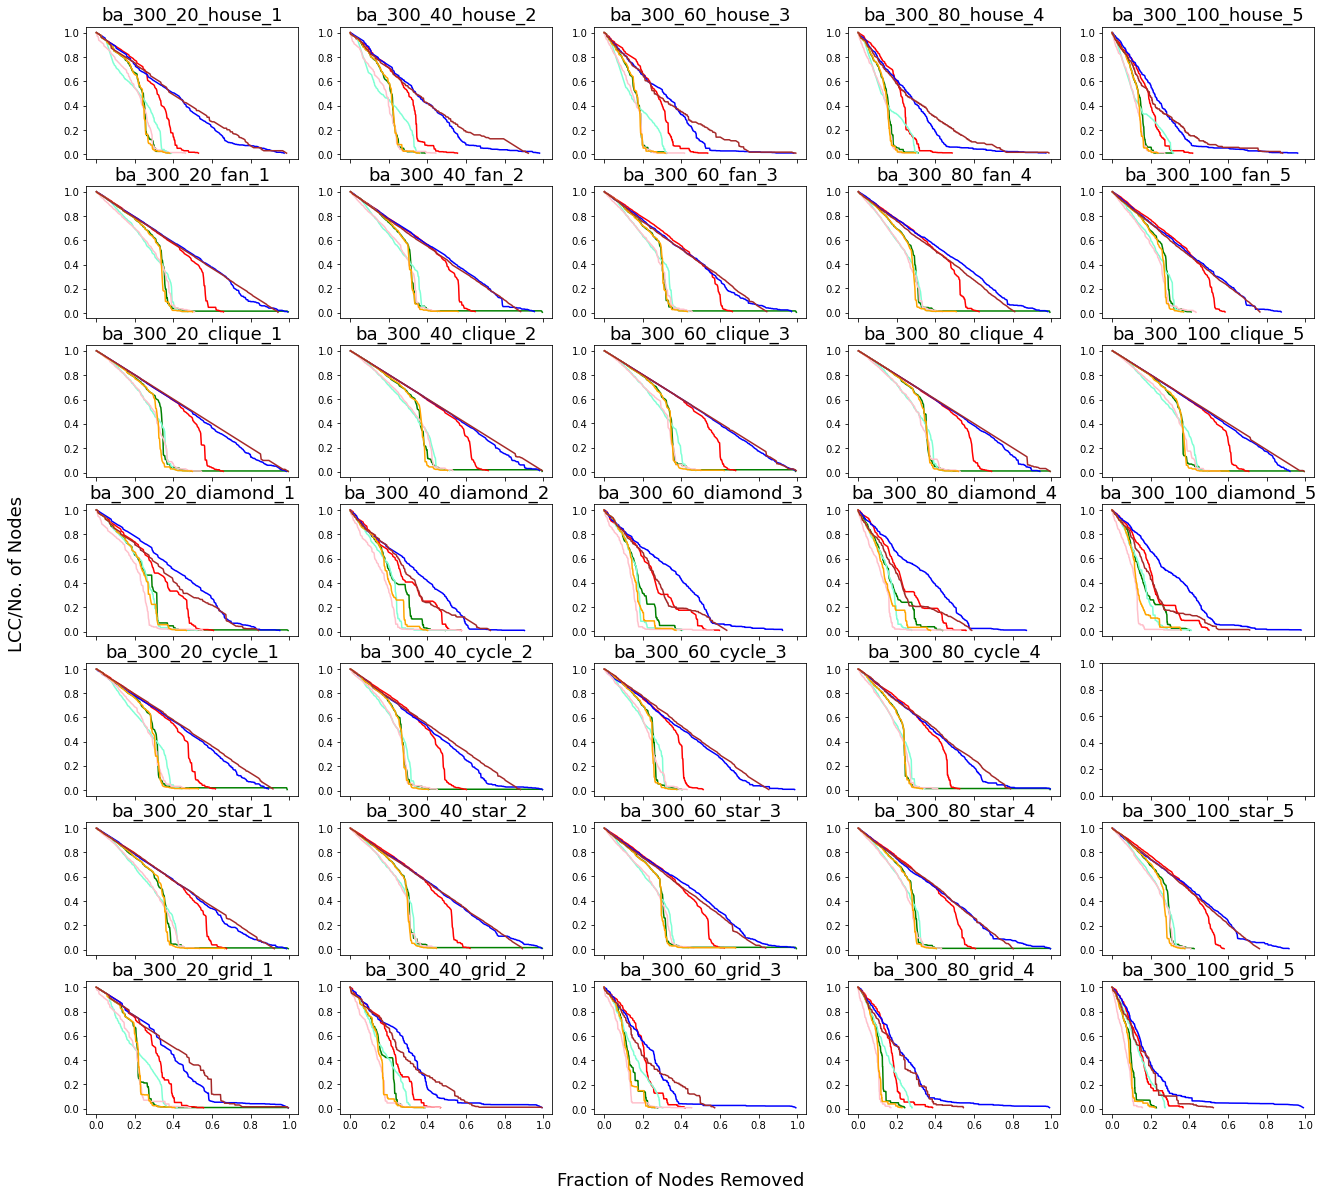

In [5]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
# 'ba_300_100_cycle_5',
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4','ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
grid_plot.pop((5*5 -1))
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"BA_Motifs",grid_plot,[x,y])


## Tree

tree_8_20_house_1 ,[248, 343, 57, 195, 427, 60, 428, 139, 111, 10, 50, 610, 272, 2, 65, 357, 23, 55, 72, 531, 67, 22, 167, 140, 260, 17, 43, 246, 204, 28, 249, 543, 83, 53, 222, 39, 37, 61, 64, 89, 51, 164, 564, 236, 368, 196, 69, 54, 542, 68, 38, 62, 94, 52, 537, 117, 532, 538, 533, 540, 148, 66, 3, 63, 143, 56, 265, 239, 183, 40, 218, 235, 240, 151, 92, 534, 70, 259, 200, 1, 233, 35, 45, 153, 161, 171, 209, 115, 225, 277, 379, 426, 474, 173, 44, 48, 215, 216, 250, 59, 15, 149, 155, 157, 159, 175, 177, 184, 193, 198, 202, 206, 210, 212, 226, 228, 242, 244, 252, 254, 256, 262, 266, 268, 270, 278, 47, 447, 590, 419, 108, 13, 162, 172, 188, 536, 352, 535]
[551, 63, 579, 556, 578, 609, 4, 13, 43, 56, 16, 567, 153, 562, 23, 58, 260, 590, 368, 94, 248, 70, 499, 596, 274, 559, 543, 69, 24, 116, 535, 59, 32, 192, 22, 14, 71, 20, 570, 537, 275, 52, 547, 19, 34, 574, 273, 50, 65, 55, 44, 552, 610, 587, 534, 539, 478, 231, 583, 236, 343, 244, 88, 83, 37, 195, 145, 57, 68, 61, 176, 35, 180, 40, 4

[204, 124, 228, 94, 75, 148, 120, 100, 192, 121, 174, 191, 84, 227, 226, 55, 146, 132, 6, 119, 29, 30, 197, 110, 158, 155, 180, 81, 193, 76, 116, 18, 24, 19, 706, 216, 661, 108, 48, 184, 144, 651, 16, 12, 196, 28, 173, 22, 103, 21, 15, 254, 626, 20, 92, 17, 125, 64, 172, 195, 145, 87, 183, 106, 118, 67, 83, 627, 708, 179, 188, 149, 194, 131, 147, 203, 11, 2, 215, 225, 648, 646, 162, 551, 553, 161, 102, 199, 210, 140, 70, 139, 536, 537, 246, 160, 1, 68, 166, 165, 123, 150, 235, 236, 109, 209, 200, 374, 656, 88, 90, 66, 583, 581, 63, 115, 105, 198, 143, 114, 589, 533, 531, 27, 526, 557, 686, 511, 631, 25, 26, 340, 687, 365, 185, 234, 505, 559, 562, 564, 633, 207, 221, 77, 571, 573, 462, 547, 549, 576, 578, 611, 613, 710, 497, 130, 658, 541, 543, 591, 593, 616, 618, 681, 683, 175, 206, 208, 569, 567, 652, 524, 522, 519, 517, 512, 241, 671, 673, 214, 79, 93, 696, 701, 170, 167, 670, 662, 644, 642, 677, 679, 621, 152, 604, 602, 587, 315]
[116, 84, 706, 11, 16, 22, 2, 76, 148, 228, 100, 192,

[184, 150, 96, 168, 80, 190, 136, 24, 191, 541, 192, 5, 163, 93, 120, 208, 149, 212, 128, 104, 186, 112, 110, 180, 79, 121, 88, 69, 203, 122, 29, 40, 25, 78, 183, 71, 44, 681, 801, 546, 13, 10, 124, 223, 107, 247, 179, 23, 75, 87, 115, 200, 445, 16, 141, 786, 26, 127, 245, 140, 65, 68, 147, 207, 146, 142, 158, 648, 646, 106, 126, 9, 15, 30, 8, 145, 173, 164, 167, 135, 119, 211, 204, 129, 77, 171, 195, 221, 228, 227, 235, 563, 561, 1, 788, 130, 170, 682, 148, 558, 556, 236, 234, 114, 109, 199, 201, 49, 197, 196, 181, 185, 731, 172, 678, 676, 668, 666, 653, 651, 76, 601, 182, 66, 251, 202, 58, 237, 238, 108, 102, 198, 189, 165, 166, 36, 553, 551, 252, 42, 169, 707, 706, 174, 536, 531, 511, 577, 761, 741, 18, 27, 22, 763, 139, 572, 574, 143, 579, 175, 356, 465, 494, 131, 582, 584, 151, 159, 187, 214, 215, 242, 603, 661, 663, 611, 613, 606, 608, 621, 623, 111, 123, 67, 752]
[736, 112, 50, 120, 168, 5, 801, 16, 84, 25, 546, 10, 191, 8, 29, 79, 99, 53, 136, 71, 671, 61, 40, 78, 541, 13, 64, 

[681, 621, 896, 881, 571, 821, 776, 84, 123, 606, 100, 796, 797, 646, 696, 871, 791, 726, 546, 80, 856, 686, 641, 651, 119, 106, 125, 761, 110, 91, 731, 826, 851, 626, 701, 841, 876, 816, 846, 756, 766, 866, 901, 721, 711, 206, 566, 562, 741, 716, 120, 781, 811, 801, 68, 596, 771, 108, 616, 661, 126, 676, 521, 536, 586, 551, 787, 673, 807, 806, 832, 90, 192, 751, 836, 886, 631, 122, 234, 634, 656, 527, 910, 96, 746, 78, 526, 185, 666, 592, 908, 511, 19, 637, 150, 691, 219, 891, 37, 861, 736, 89, 542, 597, 50, 517, 1, 8, 36, 531, 556, 6, 11, 82, 558, 165, 273, 582, 581, 602, 601, 47, 10, 26, 613, 20, 25, 171, 16, 579, 707, 706, 85, 86, 124, 577, 104, 70, 69, 103, 97, 228, 60, 71, 46, 56, 27, 28, 57, 114, 93, 111, 65, 117, 66, 118, 87, 31, 64, 15, 127, 177, 145, 77, 98, 99, 225, 72, 164, 163, 81, 79, 83, 105, 737, 671, 611, 107, 203]
[180, 123, 30, 234, 126, 125, 108, 119, 106, 151, 37, 154, 114, 155, 110, 145, 186, 177, 166, 127, 896, 182, 102, 150, 240, 69, 152, 164, 83, 144, 204, 100,

tree_8_100_house_5 ,[11, 307, 42, 36, 356, 91, 43, 211, 218, 18, 108, 120, 248, 271, 135, 319, 197, 6, 93, 58, 603, 828, 55, 69, 255, 167, 543, 293, 611, 604, 53, 435, 23, 66, 347, 31, 263, 96, 644, 226, 284, 288, 360, 291, 47, 627, 191, 609, 708, 216, 249, 799, 581, 256, 312, 311, 282, 118, 159, 296, 804, 27, 180, 82, 127, 583, 363, 75, 593, 864, 623, 102, 224, 64, 996, 405, 26, 72, 260, 160, 277, 615, 923, 620, 202, 169, 231, 285, 0, 227, 111, 605, 629, 601, 297, 821, 608, 598, 294, 175, 219, 40, 591, 65, 715, 628, 637, 51, 600, 639, 222, 236, 710, 621, 643, 63, 188, 223, 580, 67, 426, 587, 584, 158, 585, 588, 634, 612, 247, 630, 631, 89, 599, 586, 626, 266, 733, 662, 229, 274, 268, 242, 21, 52, 641, 244, 616, 182, 416, 37, 685, 68, 719, 57, 62, 161, 275, 582, 595, 613, 614, 640, 642, 577, 808, 455, 279, 624, 384, 254, 881, 48, 154, 151, 4, 3, 50, 61, 147, 205, 239, 330, 342, 352, 374, 394, 430, 494, 506, 536, 548, 573, 594, 173, 7, 49, 696, 925, 998, 243, 606, 882, 409, 38, 54, 152,

[641, 645, 130, 642, 643, 644, 10, 258, 128, 581, 585, 582, 583, 584, 646, 649, 135, 648, 67, 647, 650, 586, 590, 589, 587, 588, 967, 970, 968, 969, 966, 455, 846, 849, 335, 848, 847, 850, 167, 556, 559, 560, 558, 557, 30, 338, 35, 72, 145, 931, 934, 933, 935, 932, 301, 666, 669, 668, 348, 173, 670, 667, 776, 265, 779, 780, 379, 778, 132, 777, 771, 774, 260, 775, 772, 773, 977, 238, 978, 980, 979, 976, 36, 17, 526, 530, 527, 528, 529, 781, 327, 163, 784, 270, 783, 782, 785, 686, 175, 689, 690, 687, 87, 688, 921, 410, 925, 924, 922, 923, 856, 860, 857, 345, 172, 858, 859, 566, 570, 569, 568, 567, 517, 518, 371, 519, 520, 516, 626, 630, 629, 946, 949, 948, 947, 950, 435, 217, 108, 796, 285, 800, 142, 797, 799, 798, 881, 885, 370, 836, 839, 325, 838, 837, 162, 840, 876, 365, 182, 880, 877, 878, 879, 317, 158, 916, 405, 202, 98, 198, 398, 197, 736, 739, 225, 740, 737, 738, 456, 112, 227, 113, 561, 564, 563, 565, 562, 766, 255, 127, 769, 768, 770, 767, 706, 709, 195, 710, 707, 708, 105, 211

tree_8_40_fan_2 ,[544, 538, 58, 180, 6, 36, 16, 20, 125, 44, 4, 67, 49, 32, 105, 28, 26, 241, 73, 83, 253, 128, 131, 196, 68, 9, 108, 47, 124, 35, 46, 43, 37, 117, 72, 45, 48, 190, 110, 66, 63, 42, 162, 18, 113, 182, 200, 40, 137, 152, 70, 266, 93, 25, 119, 2, 237, 259, 159, 53, 55, 149, 52, 56, 282, 187, 155, 209, 268, 34, 122, 126, 61, 172, 274, 232, 174, 213, 226, 5, 121, 276, 280, 192, 247, 261, 59, 147, 153, 157, 167, 170, 176, 178, 183, 185, 188, 194, 197, 201, 218, 220, 222, 224, 251, 263, 277, 77, 38, 413, 258, 457, 257, 151]
[26, 16, 46, 59, 10, 351, 27, 96, 9, 4, 36, 22, 121, 125, 25, 44, 7, 38, 69, 118, 66, 48, 116, 248, 39, 50, 72, 117, 92, 68, 30, 5, 17, 28, 49, 235, 20, 35, 218, 272, 114, 73, 265, 64, 63, 43, 51, 61, 196, 353, 264, 109, 47, 205, 233, 115, 175, 269, 159, 67, 93, 274, 414, 250, 42, 260, 119, 237, 83, 254, 257, 0, 45, 151, 190, 198, 167, 249, 147, 157, 199, 282, 71, 206, 212, 6, 413, 253, 162, 220, 149, 240, 126, 258, 40, 277, 236, 110, 200, 255, 234, 273, 2

[117, 519, 526, 125, 120, 62, 4, 257, 551, 320, 56, 113, 415, 207, 114, 103, 229, 459, 112, 226, 345, 287, 143, 225, 172, 451, 493, 85, 246, 72, 520, 145, 146, 292, 450, 436, 45, 91, 183, 368, 310, 154, 76, 37, 2, 68, 138, 278, 511, 0, 137, 1, 275, 561, 400, 199, 99, 21, 43, 372, 185, 92, 186, 438, 88, 52, 430, 214, 106, 213, 458, 228, 95, 47, 245, 122, 60, 31, 64, 63, 128, 527, 130, 261, 312, 155, 77, 116, 57, 233, 468, 284, 141, 220, 217, 442, 472, 235, 382, 190, 94, 46, 22, 10, 457, 267, 133, 61, 123, 124, 247, 30, 495, 50, 159, 102, 205, 79, 32, 66, 134, 270, 65, 132, 266, 15, 240, 100, 49, 24, 286, 202, 548, 296, 147, 142, 70, 17, 35, 71, 144, 13, 28, 58, 6, 14, 27, 55, 118, 29, 237, 476, 59, 522, 119, 239, 480, 218, 393, 196, 108, 53, 33, 447, 67, 223, 111, 224, 383, 191, 161, 80, 39, 19, 9, 20, 42, 86, 281, 140, 69, 34, 16, 7, 3, 8, 18, 38, 78, 157, 316, 392, 195, 97, 48, 23, 11, 5, 90, 181, 182, 44, 366, 363, 249, 499, 51, 25, 289, 12, 545, 272, 26, 135, 54, 362, 109, 180, 219,

[180, 205, 120, 70, 150, 210, 215, 220, 130, 235, 185, 175, 145, 135, 125, 244, 80, 195, 160, 140, 35, 105, 25, 224, 50, 203, 365, 188, 132, 110, 32, 85, 187, 250, 90, 129, 209, 207, 254, 30, 236, 75, 16, 108, 170, 226, 26, 193, 165, 201, 21, 20, 400, 159, 94, 73, 115, 60, 604, 200, 27, 19, 138, 455, 95, 28, 374, 22, 118, 15, 153, 5, 18, 78, 98, 113, 100, 154, 169, 127, 179, 122, 131, 143, 81, 248, 133, 249, 173, 206, 213, 119, 216, 23, 4, 91, 134, 137, 166, 214, 83, 174, 77, 315, 144, 116, 114, 425, 204, 0, 247, 253, 149, 3, 128, 29, 103, 111, 335, 88, 92, 295, 380, 563, 561, 330, 305, 370, 460, 480, 586, 17, 161, 385, 470, 557, 31, 177, 61, 232, 211, 202, 96, 87, 358, 340, 148, 67, 72, 142, 440, 242, 475, 109, 435, 24, 99, 395, 97, 172, 162, 69, 252, 112]
[35, 60, 10, 32, 16, 236, 26, 180, 193, 20, 25, 130, 30, 37, 39, 50, 55, 58, 94, 3, 250, 165, 23, 67, 100, 108, 207, 21, 400, 45, 110, 115, 5, 140, 41, 85, 120, 188, 56, 90, 73, 40, 105, 129, 209, 88, 95, 38, 125, 203, 244, 128, 70,

tree_8_40_clique_2 ,[3, 21, 480, 382, 37, 224, 131, 62, 51, 35, 47, 6, 163, 5, 107, 34, 185, 116, 155, 134, 118, 7, 110, 120, 58, 42, 137, 45, 11, 64, 53, 66, 49, 202, 44, 156, 117, 36, 150, 10, 63, 266, 159, 57, 265, 55, 17, 38, 23, 24, 25, 33, 222, 52, 203, 169, 165, 183, 141, 176, 50, 261, 65, 81, 122, 119, 216, 240, 90, 95, 505, 152, 205, 106, 4, 245, 68, 151, 157, 124, 146, 166, 135, 138, 142, 144, 148, 170, 172, 174, 180, 188, 190, 192, 194, 196, 199, 210, 218, 220, 234, 247, 249, 251, 253, 255, 257, 259, 407, 56, 61, 158, 408]
[40, 117, 28, 54, 14, 66, 383, 93, 80, 0, 130, 92, 157, 169, 105, 318, 395, 305, 214, 339, 462, 406, 439, 330, 360, 429, 474, 451, 282, 418, 372, 348, 181, 143, 193, 204, 151, 4, 51, 256, 22, 227, 31, 55, 34, 222, 131, 243, 20, 60, 48, 79, 71, 207, 25, 68, 201, 21, 32, 37, 35, 67, 6, 45, 61, 49, 58, 208, 232, 184, 38, 46, 189, 62, 44, 268, 52, 154, 64, 233, 185, 150, 155, 140, 159, 81, 218, 269, 239, 63, 141, 198, 271, 36, 138, 253, 267, 47, 176, 200, 237,

[6, 169, 23, 177, 18, 1, 65, 188, 319, 17, 60, 341, 31, 37, 47, 95, 320, 356, 290, 327, 342, 395, 417, 425, 139, 245, 224, 22, 29, 314, 49, 43, 35, 308, 362, 46, 208, 266, 67, 96, 55, 103, 121, 222, 373, 78, 205, 225, 493, 364, 372, 456, 232, 272, 214, 134, 143, 74, 80, 99, 73, 252, 360, 210, 281, 316, 353, 354, 368, 374, 392, 394, 424, 439, 445, 473, 494, 148, 233, 248, 123, 77, 86, 9, 192, 12, 41, 254, 68, 42, 481, 176, 291, 293, 294, 309, 351, 352, 381, 411, 442, 450, 476, 483, 485, 486, 497, 508, 36, 154, 246, 271, 265, 155, 197, 53, 242, 268, 163, 165, 112, 27, 149, 10, 44, 5, 11, 24, 28, 71, 159, 160, 175, 203, 226, 260, 267, 122, 129, 228, 240, 253, 198, 2, 16, 30, 70, 115, 164, 275, 335, 366, 104, 140, 235, 84, 59, 131, 157, 19, 403, 57, 258, 250, 238, 402, 433, 38, 396, 397, 108, 97, 144, 201, 211, 249, 106, 446, 118, 69, 88, 117, 166, 172, 124, 153, 257, 26, 64, 61, 336, 365, 52, 190, 114, 234, 173, 182, 215, 207, 161, 174, 259, 477, 274, 307, 448, 158, 282, 315, 350, 379, 41

tree_8_100_clique_5 ,[3, 76, 0, 210, 6, 54, 143, 61, 51, 63, 35, 29, 10, 8, 36, 96, 179, 125, 38, 43, 53, 79, 102, 60, 45, 71, 58, 111, 264, 47, 219, 142, 46, 44, 242, 42, 59, 40, 50, 195, 267, 251, 158, 23, 261, 72, 180, 237, 271, 257, 11, 109, 206, 234, 128, 254, 66, 112, 93, 104, 13, 133, 140, 259, 177, 152, 144, 170, 151, 174, 185, 201, 48, 55, 165, 65, 172, 159, 224, 230, 247, 108, 68, 148, 161, 163, 167, 175, 183, 187, 190, 192, 196, 211, 221, 226, 228, 232, 249, 265, 238, 9, 145, 157, 186, 202, 243, 392, 345, 356]
[6, 108, 92, 11, 18, 38, 208, 65, 24, 53, 43, 72, 160, 165, 260, 234, 141, 48, 147, 59, 32, 369, 179, 154, 411, 250, 199, 110, 275, 188, 329, 194, 210, 241, 175, 103, 170, 403, 216, 77, 333, 220, 389, 458, 131, 255, 126, 87, 229, 0, 281, 136, 355, 82, 120, 443, 115, 498, 270, 483, 183, 299, 324, 462, 407, 97, 280, 390, 478, 364, 314, 370, 276, 293, 384, 448, 350, 14, 421, 375, 439, 395, 319, 467, 308, 493, 430, 345, 337, 489, 303, 340, 360, 416, 434, 31, 39, 76, 453, 1

[75, 95, 223, 199, 233, 224, 124, 236, 209, 25, 212, 202, 132, 136, 15, 2, 162, 175, 156, 4, 3, 139, 34, 68, 174, 180, 90, 543, 141, 113, 17, 21, 22, 230, 94, 251, 102, 19, 112, 171, 42, 625, 26, 231, 28, 29, 197, 201, 238, 18, 24, 23, 244, 243, 161, 71, 137, 605, 109, 78, 74, 168, 173, 119, 92, 198, 108, 66, 151, 170, 169, 188, 210, 106, 154, 148, 147, 172, 120, 164, 204, 253, 252, 62, 91, 163, 577, 107, 135, 129, 130, 128, 254, 247, 229, 110, 529, 193, 363, 179, 131, 72, 127, 122, 103, 97, 194, 82, 79, 153, 88, 155, 248, 140, 203, 142, 563, 589, 560, 158, 604, 20, 16, 452, 564, 562, 414, 228, 149, 591, 590, 592, 189, 49, 87, 433, 335, 55, 117, 115, 491, 138, 56, 455, 600, 0, 629, 623, 619, 607, 595, 599, 597, 565, 567, 568, 566, 576, 571, 573, 575, 541, 544, 542, 535, 539, 537, 540, 553, 579, 580, 578, 61, 14, 547, 608, 610, 609, 613, 615, 617, 618, 105, 5, 585, 549, 551, 552, 523, 533, 534, 531, 624, 621, 628, 439, 13, 528, 525, 527, 606, 602, 521, 520, 518, 522, 118, 375]
[529, 521

[541, 183, 23, 727, 26, 1, 523, 709, 679, 631, 120, 739, 601, 610, 532, 84, 552, 595, 2, 686, 252, 155, 703, 148, 215, 132, 661, 617, 565, 667, 156, 127, 535, 649, 14, 647, 36, 203, 228, 525, 723, 583, 515, 558, 559, 25, 200, 655, 710, 697, 192, 66, 673, 91, 8, 551, 21, 28, 619, 691, 733, 745, 16, 19, 517, 175, 683, 566, 669, 718, 27, 153, 582, 639, 685, 181, 187, 204, 20, 72, 605, 721, 213, 571, 589, 625, 24, 586, 708, 650, 22, 675, 231, 643, 60, 48, 61, 118, 211, 15, 82, 37, 110, 68, 374, 511, 664, 715, 635, 524, 69, 637, 519, 729, 530, 537, 543, 557, 561, 573, 581, 591, 597, 608, 618, 621, 627, 657, 693, 699, 735, 741, 747, 79, 85, 103, 111, 89, 94, 96, 62, 64, 88, 114, 232, 239, 568, 83, 100, 108, 244, 38, 71, 135, 196, 245, 102, 116, 176, 688, 70, 80, 81, 86, 92, 104, 109, 112, 117, 151, 516, 645, 662, 584, 606, 636, 652, 684, 707, 712, 716, 52, 149, 157, 197, 222]
[31, 208, 191, 554, 276, 149, 161, 158, 313, 45, 122, 237, 107, 193, 558, 532, 226, 248, 205, 128, 568, 573, 88, 132,

[128, 236, 214, 119, 687, 159, 176, 218, 123, 72, 196, 164, 200, 24, 201, 199, 133, 242, 215, 226, 225, 177, 210, 209, 152, 91, 76, 243, 308, 241, 29, 211, 246, 70, 136, 197, 80, 134, 129, 69, 74, 179, 724, 84, 110, 144, 96, 203, 23, 16, 659, 95, 165, 163, 166, 40, 135, 111, 113, 235, 28, 116, 195, 115, 79, 9, 127, 83, 171, 172, 178, 32, 131, 30, 126, 799, 114, 155, 27, 151, 18, 78, 204, 579, 68, 71, 17, 296, 162, 666, 202, 198, 130, 6, 217, 175, 26, 109, 86, 180, 125, 188, 185, 190, 186, 44, 124, 118, 232, 182, 181, 73, 102, 43, 10, 94, 187, 244, 1, 577, 553, 673, 103, 511, 795, 762, 834, 740, 793, 714, 25, 106, 859, 547, 67, 516, 864, 863, 861, 844, 591, 546, 518, 841, 843, 842, 338, 139, 223, 183, 520, 521, 522, 681, 541, 543, 545, 143, 619, 621, 623, 624, 675, 678, 677, 515, 513, 167, 207, 227, 460, 439, 446, 502, 679, 22, 194, 555, 558, 557, 386, 581, 285, 597, 20, 477, 233, 318, 276, 680, 682, 122, 15, 140, 442, 339, 668, 665, 663, 661, 655, 191, 649, 650, 651, 652, 637, 639, 641

[690, 686, 810, 87, 770, 227, 366, 758, 499, 658, 716, 420, 667, 757, 919, 498, 944, 974, 429, 665, 785, 613, 424, 295, 899, 774, 90, 940, 927, 114, 949, 728, 968, 964, 762, 693, 202, 654, 738, 21, 782, 688, 289, 270, 212, 267, 290, 745, 225, 733, 869, 549, 669, 900, 711, 814, 855, 878, 957, 701, 804, 27, 712, 52, 223, 867, 287, 417, 76, 540, 64, 552, 247, 882, 802, 765, 93, 858, 932, 862, 911, 231, 695, 142, 672, 985, 981, 908, 990, 850, 915, 448, 683, 813, 351, 897, 707, 916, 659, 38, 776, 887, 939, 843, 731, 662, 132, 924, 22, 965, 943, 761, 973, 477, 794, 598, 868, 324, 670, 241, 923, 732, 971, 963, 720, 903, 710, 956, 715, 593, 666, 630, 19, 726, 639, 586, 859, 461, 334, 254, 910, 872, 825, 304, 580, 502, 555, 67, 648, 649, 619, 610, 668, 622, 597, 650, 602, 652, 614, 638, 272, 156, 631, 60, 474, 347, 377, 625, 635, 775, 399, 609, 694, 196, 532, 566, 696, 822, 727, 744, 753, 799, 3, 611, 599, 16, 633, 26, 118, 615, 434, 184, 123, 315, 365, 655, 30, 617, 640, 166, 250, 187, 331, 63

[556, 766, 684, 424, 211, 631, 516, 943, 432, 215, 692, 805, 294, 146, 655, 144, 895, 384, 191, 592, 715, 687, 661, 520, 353, 848, 317, 333, 825, 907, 396, 197, 917, 604, 877, 366, 888, 382, 190, 94, 727, 216, 107, 775, 577, 841, 304, 330, 952, 889, 378, 532, 311, 823, 312, 151, 155, 637, 579, 757, 246, 697, 43, 264, 769, 258, 931, 961, 450, 863, 257, 128, 63, 524, 608, 373, 920, 630, 339, 169, 535, 793, 282, 140, 69, 837, 175, 87, 176, 354, 799, 288, 143, 71, 583, 781, 270, 134, 572, 643, 901, 549, 285, 142, 45, 91, 132, 358, 183, 368, 979, 468, 925, 817, 306, 152, 75, 871, 739, 829, 318, 158, 667, 156, 77, 717, 653, 455, 738, 542, 360, 179, 562, 710, 831, 495, 247, 619, 968, 350, 957, 708, 283, 141, 70, 34, 751, 819, 887, 835, 324, 161, 694, 879, 613, 629, 939, 122, 565, 615, 298, 985, 474, 815, 673, 162, 721, 518, 787, 745, 234, 973, 462, 230, 547, 937, 426, 212, 105, 955, 444, 777, 723, 685, 174, 595, 47, 356, 95, 192, 853, 342, 170, 869, 90, 783, 645, 981, 12, 859, 348, 707, 585, 

[190, 165, 68, 214, 529, 65, 230, 160, 224, 242, 246, 80, 184, 187, 186, 171, 229, 211, 222, 244, 243, 67, 124, 149, 182, 130, 140, 166, 232, 209, 723, 153, 829, 223, 134, 245, 73, 946, 99, 180, 145, 35, 217, 991, 199, 27, 231, 220, 112, 141, 577, 164, 174, 934, 16, 45, 751, 985, 20, 661, 62, 159, 19, 579, 254, 559, 172, 613, 100, 95, 53, 189, 219, 197, 5, 23, 24, 194, 97, 25, 241, 78, 154, 77, 572, 75, 8, 212, 10, 1, 643, 84, 14, 142, 206, 177, 234, 621, 258, 247, 235, 44, 1009, 207, 248, 877, 743, 757, 619, 181, 15, 71, 178, 57, 119, 46, 129, 188, 917, 918, 167, 210, 1081, 216, 2, 583, 708, 558, 557, 554, 556, 771, 1006, 571, 573, 574, 862, 847, 944, 741, 739, 744, 879, 629, 997, 563, 891, 647, 648, 645, 721, 724, 722, 1087, 976, 983, 1059, 889, 236, 699, 745, 1004, 1057, 578, 96, 511, 537, 691, 817, 102, 69, 755, 996, 894, 562, 973, 943, 864, 663, 72, 1060, 979, 290, 630, 628, 626, 147, 893, 820, 410, 1011, 1010, 1012, 316, 108, 945, 59, 61, 580, 83, 202, 878, 880, 916, 914, 1085, 1

tree_8_20_cycle_1 ,[54, 53, 2, 5, 520, 521, 260, 59, 79, 66, 82, 52, 57, 39, 9, 62, 63, 11, 50, 46, 55, 235, 48, 65, 38, 36, 42, 45, 35, 16, 47, 64, 51, 58, 49, 18, 19, 22, 23, 30, 31, 262, 212, 259, 150, 183, 208, 211, 187, 156, 530, 21, 535, 539, 541, 56, 529, 532, 538, 533, 537, 34, 37, 43, 44, 60, 61, 468, 524, 247, 3, 555, 196, 138, 534, 264, 40, 41, 314, 153, 214, 177, 139, 147, 14, 133, 135, 141, 232, 145, 242, 167, 160, 236, 143, 238, 181, 248, 175, 169, 151, 162, 185, 171, 193, 189, 173, 226, 179, 197, 191, 201, 199, 254, 244, 203, 230, 205, 209, 252, 216, 218, 220, 222, 240, 224, 228, 250, 256]
[15, 4, 16, 52, 66, 25, 28, 21, 22, 14, 59, 1, 553, 38, 24, 63, 19, 213, 40, 57, 65, 39, 235, 23, 262, 41, 69, 3, 62, 212, 570, 26, 46, 54, 34, 588, 49, 64, 149, 159, 47, 242, 214, 184, 58, 60, 226, 207, 535, 45, 530, 36, 42, 55, 211, 541, 589, 17, 150, 37, 43, 44, 48, 50, 51, 574, 579, 584, 166, 240, 260, 539, 533, 571, 545, 552, 188, 529, 532, 538, 35, 261, 155, 215, 258, 542, 575, 5

[166, 25, 169, 153, 229, 199, 259, 262, 263, 206, 142, 80, 265, 178, 83, 140, 544, 154, 130, 391, 223, 106, 64, 545, 546, 564, 568, 361, 96, 116, 188, 225, 244, 102, 557, 386, 11, 569, 269, 266, 242, 12, 95, 90, 29, 30, 38, 162, 226, 170, 254, 549, 563, 565, 566, 152, 228, 264, 135, 136, 149, 163, 173, 231, 36, 42, 71, 127, 151, 552, 553, 230, 3, 562, 137, 219, 43, 185, 20, 55, 253, 0, 21, 543, 437, 24, 192, 251, 167, 548, 246, 558, 561, 179, 45, 204, 208, 334, 490, 190, 196, 202, 212, 239, 261, 54, 411, 487, 49, 94, 547, 554, 160, 256, 216, 181, 148, 176, 213, 217, 238, 258, 260, 177, 211, 462, 93, 283, 209, 214, 222, 7, 14, 32, 86, 117, 567, 348, 575, 641, 704, 714, 22, 65, 6, 63, 69, 107, 233, 556, 551, 555, 559, 67, 88, 31, 59, 131, 111, 139, 215, 205, 141, 145, 187, 198, 248, 574, 593, 627, 679, 684, 692, 701, 703, 720, 79, 512, 542, 257, 337, 364, 580, 595, 613, 619, 629, 648, 653, 672, 674, 705, 632, 50, 207, 268, 270, 194, 126, 133, 599, 710, 203, 550, 560, 91, 115, 165, 172, 2

[48, 174, 214, 176, 149, 254, 183, 205, 142, 244, 231, 226, 171, 277, 189, 188, 163, 35, 573, 597, 569, 108, 250, 192, 245, 29, 133, 578, 579, 586, 130, 127, 321, 201, 274, 464, 584, 160, 572, 574, 589, 601, 339, 533, 551, 24, 128, 65, 1, 141, 177, 196, 585, 598, 200, 213, 223, 241, 266, 257, 566, 581, 590, 602, 604, 151, 148, 570, 594, 94, 207, 18, 37, 66, 80, 178, 92, 181, 219, 286, 393, 124, 154, 167, 203, 246, 41, 184, 269, 152, 362, 98, 76, 131, 146, 173, 204, 208, 230, 238, 240, 248, 276, 567, 576, 582, 587, 588, 592, 595, 596, 599, 600, 603, 571, 187, 222, 253, 168, 193, 243, 247, 255, 259, 272, 273, 156, 265, 115, 143, 180, 268, 86, 100, 118, 164, 199, 516, 150, 21, 74, 289, 556, 147, 190, 262, 206, 90, 12, 28, 33, 68, 575, 577, 580, 591, 568, 583, 419, 425, 643, 686, 707, 751, 765, 766, 159, 110, 267, 117, 38, 237, 252, 326, 14, 70, 84, 121, 559, 34, 44, 54, 55, 106, 135, 593, 105, 129, 82, 113, 10, 45, 75, 157, 27, 56, 212, 63, 620, 634, 642, 646, 647, 708, 712, 720, 827, 840

[18, 12, 30, 7, 24, 217, 42, 51, 110, 6, 36, 48, 90, 114, 92, 102, 60, 66, 19, 78, 96, 120, 72, 84, 21, 28, 75, 81, 101, 162, 216, 22, 126, 225, 33, 127, 174, 180, 156, 210, 228, 511, 755, 144, 175, 234, 867, 53, 132, 168, 192, 70, 111, 105, 138, 150, 198, 240, 252, 944, 31, 93, 99, 117, 147, 246, 1, 565, 770, 914, 782, 793, 891, 969, 123, 614, 778, 895, 988, 606, 218, 835, 856, 871, 549, 233, 799, 823, 847, 859, 931, 955, 27, 79, 88, 787, 560, 811, 907, 669, 131, 646, 694, 697, 715, 733, 741, 805, 817, 829, 841, 877, 883, 901, 919, 925, 937, 961, 973, 865, 967, 69, 106, 109, 115, 619, 949, 979, 76, 82, 91, 94, 100, 118, 124, 889, 795, 853, 897, 957, 985, 17, 23]
[160, 230, 251, 261, 94, 185, 285, 274, 244, 113, 172, 167, 126, 194, 579, 121, 215, 151, 586, 613, 97, 393, 58, 103, 200, 67, 149, 590, 607, 611, 614, 624, 157, 64, 43, 133, 193, 268, 258, 32, 576, 589, 591, 601, 603, 606, 155, 300, 201, 6, 47, 76, 21, 90, 132, 7, 196, 489, 146, 592, 595, 588, 51, 254, 283, 270, 87, 74, 70, 2

[733, 778, 96, 66, 125, 65, 95, 1048, 215, 85, 63, 211, 925, 80, 118, 90, 70, 110, 120, 75, 140, 71, 100, 186, 225, 175, 205, 92, 30, 20, 190, 40, 10, 43, 50, 60, 231, 195, 15, 79, 89, 525, 649, 99, 5, 57, 25, 119, 84, 64, 109, 673, 674, 715, 538, 48, 104, 746, 787, 697, 793, 691, 685, 811, 763, 117, 6, 55, 207, 914, 998, 671, 1105, 913, 1106, 1079, 920, 511, 854, 853, 543, 565, 637, 553, 967, 1003, 53, 76, 106, 754, 16, 46, 931, 937, 1021, 1023, 1027, 939, 1063, 187, 1051, 137, 147, 879, 955, 847, 871, 1069, 868, 841, 1039, 829, 889, 1057, 904, 907, 1041, 1015, 1099, 831, 985, 979, 711, 709, 805, 817, 823, 1087, 859, 883, 1093, 895, 949, 973, 976, 835, 991, 943, 1081, 67, 799, 727, 703, 1033, 72, 124, 123, 8, 56, 17, 36, 74, 113, 114, 77, 78, 91, 38, 1, 1045, 901, 694, 775, 751, 253, 667, 86, 83, 961, 964, 550, 877, 1011, 1009, 1075]
[140, 125, 160, 65, 66, 211, 210, 240, 155, 215, 165, 166, 180, 95, 96, 195, 198, 120, 85, 175, 170, 20, 23, 80, 40, 15, 25, 70, 71, 217, 90, 5, 10, 30, 

[200, 225, 250, 216, 74, 147, 17, 204, 50, 125, 133, 238, 100, 128, 91, 171, 192, 173, 205, 31, 25, 7, 224, 20, 10, 13, 1, 5, 29, 84, 23, 75, 18, 19, 88, 110, 26, 103, 89, 96, 215, 70, 106, 94, 67, 82, 191, 78, 71, 375, 242, 121, 79, 97, 237, 127, 181, 134, 156, 169, 69, 148, 155, 172, 182, 199, 203, 109, 174, 114, 249, 247, 245, 254, 98, 233, 57, 228, 61, 253, 108, 206, 80, 188, 87, 83, 81, 76, 145, 129, 68, 235, 234, 231, 227, 105, 92, 42, 65, 146, 130, 119, 232, 104, 223, 27, 21, 16, 286, 22, 120, 435, 425, 428, 518, 275, 362, 325, 359, 140, 143, 177, 170, 136, 62, 252, 243, 14, 112, 149, 122, 503, 117, 229, 475, 222, 2, 380, 187, 166, 271, 415, 193, 305]
[17, 60, 25, 50, 20, 10, 13, 205, 7, 125, 5, 86, 224, 133, 100, 38, 84, 96, 88, 19, 55, 110, 31, 30, 91, 23, 58, 89, 103, 217, 33, 75, 1, 147, 46, 26, 192, 59, 123, 98, 175, 238, 69, 82, 171, 71, 105, 56, 57, 80, 90, 150, 200, 375, 32, 127, 209, 107, 124, 186, 204, 245, 76, 237, 135, 70, 225, 168, 72, 79, 81, 97, 106, 109, 126, 137

tree_8_60_star_3 ,[80, 235, 43, 126, 10, 107, 64, 98, 12, 227, 42, 218, 36, 467, 118, 271, 388, 45, 210, 142, 39, 97, 119, 15, 108, 51, 37, 62, 65, 46, 184, 68, 41, 70, 50, 61, 55, 38, 240, 58, 52, 44, 72, 1, 56, 34, 141, 274, 150, 275, 266, 253, 228, 193, 172, 63, 67, 278, 283, 182, 203, 69, 81, 91, 551, 191, 87, 73, 2, 246, 194, 8, 236, 99, 285, 54, 204, 272, 479, 151, 180, 208, 262, 256, 158, 268, 280, 167, 155, 178, 213, 230, 233, 257, 13, 153, 169, 173, 188, 206, 211, 215, 250, 254, 264, 281, 463, 32, 121, 195, 217, 247, 545, 117, 9, 196, 351]
[200, 285, 288, 42, 18, 266, 11, 26, 270, 81, 22, 62, 29, 80, 16, 7, 235, 52, 59, 106, 238, 76, 55, 32, 35, 51, 10, 37, 499, 177, 44, 67, 175, 198, 30, 187, 171, 141, 98, 281, 241, 224, 246, 46, 148, 68, 107, 189, 545, 258, 208, 176, 142, 38, 226, 70, 218, 45, 47, 114, 245, 257, 172, 227, 225, 261, 149, 158, 178, 50, 182, 262, 197, 464, 27, 229, 69, 276, 61, 41, 54, 8, 192, 146, 203, 60, 259, 64, 188, 196, 65, 190, 271, 170, 480, 9, 252, 58,

[173, 240, 228, 120, 278, 167, 201, 225, 7, 164, 282, 33, 199, 234, 241, 271, 265, 188, 177, 55, 231, 277, 219, 258, 268, 193, 42, 126, 217, 67, 262, 92, 34, 132, 192, 103, 174, 29, 97, 205, 207, 161, 249, 10, 157, 245, 85, 50, 215, 244, 0, 152, 200, 26, 37, 151, 153, 166, 221, 220, 229, 194, 98, 160, 28, 323, 238, 211, 239, 163, 149, 150, 213, 81, 155, 102, 25, 4, 276, 279, 275, 285, 297, 141, 185, 256, 133, 281, 388, 196, 283, 252, 226, 100, 147, 105, 204, 48, 182, 222, 146, 223, 22, 123, 27, 272, 260, 20, 214, 230, 191, 250, 9, 21, 180, 65, 82, 168, 23, 130, 242, 112, 63, 178, 563, 486, 93, 109, 57, 253, 162, 114, 548, 227, 243, 91, 53, 36, 90, 333, 246, 195, 263, 13, 52, 134, 175, 189, 203, 218, 269, 346, 347, 474, 492, 529, 295, 142, 41, 51, 45, 131, 144, 171, 118, 156, 495, 212, 232, 140, 264, 236, 233, 254, 5, 31, 46, 427, 139, 148, 202, 266, 571, 586, 546, 556, 165, 209, 170, 440, 84, 2, 14, 206, 190, 176, 349, 369, 516, 186, 255, 270, 32, 70, 247, 257, 559, 565, 584, 39, 107, 

tree_8_20_grid_1 ,[1106, 589, 756, 755, 595, 517, 495, 314, 315, 476, 588, 577, 125, 648, 590, 736, 618, 798, 663, 801, 709, 696, 710, 708, 1142, 982, 234, 177, 36, 889, 18, 824, 570, 768, 574, 139, 908, 1127, 992, 14, 833, 943, 1023, 813, 1079, 431, 684, 997, 1072, 28, 814, 62, 653, 563, 277, 60, 687, 19, 672, 614, 1196, 567, 1219, 884, 1050, 597, 599, 731, 73, 1153, 558, 147, 694, 1207, 917, 837, 1074, 976, 49, 621, 857, 750, 780, 1176, 946, 817, 726, 164, 895, 21, 794, 70, 1015, 1097, 1155, 924, 854, 1189, 882, 604, 772, 1111, 650, 1213, 23, 1081, 1045, 246, 1167, 892, 870, 744, 579, 616, 668, 865, 679, 700, 954, 840, 193, 582, 987, 793, 740, 270, 715, 1133, 921, 575, 1163, 571, 12, 635, 564, 217, 352, 242, 785, 1026, 1010, 657, 752, 226, 128, 393, 1222, 913, 984, 881, 738, 634, 619, 821, 1069, 1049, 1194, 554, 1054, 936, 203, 675, 702, 109, 584, 22, 773, 287, 38, 231, 281, 638, 627, 950, 973, 1087, 1101, 790, 326, 138, 568, 1191, 1224, 75, 724, 90, 573, 1183, 593, 58, 607, 1038, 11

[147, 653, 164, 246, 577, 954, 1044, 595, 202, 997, 919, 684, 709, 563, 19, 672, 801, 815, 495, 217, 287, 588, 62, 216, 602, 193, 928, 590, 286, 220, 98, 151, 1197, 726, 771, 943, 242, 1006, 564, 600, 837, 589, 575, 476, 908, 125, 390, 891, 932, 585, 315, 567, 578, 173, 195, 889, 921, 710, 817, 23, 258, 326, 573, 1204, 715, 885, 579, 749, 796, 215, 168, 200, 240, 233, 114, 25, 681, 981, 813, 768, 174, 864, 226, 270, 27, 649, 736, 116, 761, 1078, 1108, 593, 1087, 755, 86, 162, 1072, 594, 18, 142, 230, 689, 854, 1194, 70, 699, 719, 1158, 1163, 1208, 1223, 60, 687, 693, 1154, 1176, 1189, 1220, 596, 157, 1079, 99, 1047, 146, 247, 847, 1132, 234, 783, 763, 1017, 792, 660, 1171, 558, 568, 1124, 136, 762, 517, 740, 109, 618, 992, 580, 570, 696, 798, 1165, 185, 222, 239, 90, 265, 1049, 834, 925, 175, 1027, 601, 28, 280, 178, 36, 46, 221, 197, 14, 935, 995, 139, 931, 10, 821, 1026, 1179, 827, 677, 717, 1188, 930, 31, 1063, 63, 805, 92, 655, 163, 198, 264, 835, 867, 735, 1036, 1151, 829, 841, 10

tree_8_40_grid_2 ,[627, 310, 837, 843, 710, 720, 763, 1252, 624, 789, 793, 682, 639, 781, 625, 205, 919, 89, 804, 597, 648, 1278, 167, 30, 654, 747, 651, 719, 1447, 1603, 1776, 866, 1142, 971, 1115, 901, 1393, 1063, 297, 994, 827, 592, 1712, 768, 718, 1126, 1648, 649, 846, 864, 1272, 87, 841, 1255, 198, 1046, 957, 422, 249, 1146, 875, 981, 1105, 1036, 1075, 1066, 91, 1285, 48, 659, 600, 824, 252, 851, 612, 1295, 1466, 1338, 1321, 1358, 1107, 954, 1000, 58, 810, 1507, 1183, 586, 1086, 730, 1524, 220, 1069, 604, 1116, 698, 1387, 598, 680, 32, 25, 1034, 610, 1350, 637, 749, 643, 72, 1085, 325, 1938, 19, 105, 796, 636, 1157, 1686, 993, 645, 1877, 633, 1480, 95, 1901, 1772, 1451, 1718, 1541, 939, 1514, 1289, 632, 616, 1128, 969, 236, 5, 75, 1750, 266, 1319, 1019, 1427, 782, 294, 50, 1596, 1874, 669, 1706, 1253, 299, 1943, 1097, 1149, 1475, 464, 22, 1501, 127, 57, 611, 1933, 1258, 7, 1912, 1342, 742, 1680, 1110, 1390, 1178, 817, 1777, 1720, 1217, 1552, 623, 702, 640, 1413, 1828, 1054, 689, 8

[100, 192, 146, 246, 134, 127, 180, 132, 228, 238, 109, 195, 242, 1392, 121, 69, 123, 30, 125, 254, 1798, 67, 81, 692, 699, 694, 1307, 46, 92, 10, 1739, 24, 23, 5, 1186, 37, 1612, 1811, 1816, 1809, 88, 96, 824, 819, 812, 817, 856, 596, 17, 802, 841, 807, 814, 809, 816, 821, 1576, 1200, 1569, 1571, 1562, 1578, 1555, 1557, 1591, 227, 27, 235, 236, 6, 57, 29, 640, 1079, 714, 712, 928, 1338, 938, 931, 926, 933, 921, 916, 923, 210, 836, 909, 1779, 74, 619, 825, 1228, 105, 1887, 19, 79, 1281, 20, 86, 1634, 1641, 1636, 1629, 1631, 1038, 21, 576, 1774, 1772, 103, 1256, 25, 1783, 1784, 777, 567, 669, 574, 26, 1711, 107, 1067, 1072, 1065, 1060, 1058, 1053, 1074, 101, 1456, 1751, 903, 1743, 1347, 1755, 396, 144, 1375, 72, 1267, 1598, 1593, 1279, 1489, 1203, 1385, 1330, 1877, 1293, 1862, 957, 902, 895, 1446, 1430, 991, 1843, 84, 131, 524, 15, 682, 1451, 1458, 312, 77, 1463, 1129, 1461, 1468, 1473, 1479, 112, 730, 851, 1252, 1210, 879, 1096, 753, 1709, 772, 1515, 674, 858, 863, 868, 861, 1, 1390, 1

[1612, 777, 410, 1186, 307, 153, 76, 1279, 851, 1035, 567, 1307, 382, 190, 1308, 177, 94, 1533, 1535, 856, 1221, 141, 1456, 1853, 640, 669, 730, 1798, 510, 1576, 682, 1392, 488, 243, 536, 1538, 692, 407, 1634, 824, 1571, 1820, 957, 1028, 836, 1724, 1409, 1410, 575, 1504, 1796, 451, 225, 962, 1641, 1473, 1779, 1347, 753, 273, 1672, 1108, 895, 901, 699, 693, 841, 835, 1252, 1739, 1740, 370, 184, 91, 401, 200, 99, 986, 1637, 621, 539, 1599, 590, 1175, 950, 956, 1385, 1922, 72, 145, 1430, 714, 1682, 1887, 333, 166, 82, 1281, 319, 159, 79, 1743, 1877, 1878, 350, 1096, 1078, 524, 133, 843, 842, 397, 198, 712, 1383, 953, 755, 1784, 48, 97, 196, 394, 98, 197, 1711, 218, 1569, 1570, 1293, 1058, 531, 916, 1834, 326, 162, 1038, 1129, 1816, 1139, 772, 879, 69, 139, 279, 462, 230, 1338, 330, 1390, 1384, 1391, 78, 665, 1709, 837, 926, 599, 1463, 784, 778, 572, 1755, 1461, 1462, 1862, 1475, 1318, 1331, 1332, 1337, 1256, 427, 674, 1067, 435, 217, 108, 928, 1857, 1210, 809, 229, 114, 1774, 1773, 1591, 

tree_8_60_grid_3 ,[793, 789, 1453, 148, 758, 1084, 1156, 780, 943, 970, 604, 813, 1792, 1418, 621, 691, 574, 1110, 1560, 48, 856, 286, 905, 145, 1340, 692, 1198, 946, 33, 2357, 617, 1316, 2257, 1363, 1039, 1060, 1053, 742, 1257, 457, 1188, 200, 1154, 826, 178, 1851, 159, 1270, 1222, 902, 204, 1010, 952, 1182, 2224, 762, 1374, 640, 187, 1915, 675, 1530, 2469, 1298, 741, 2276, 254, 1876, 2427, 843, 885, 2506, 1473, 215, 783, 100, 2101, 1721, 1645, 1006, 961, 225, 1630, 1987, 784, 2585, 622, 555, 1904, 2370, 922, 767, 965, 1880, 2465, 20, 2484, 1697, 771, 1317, 1623, 1780, 509, 1157, 827, 636, 1200, 825, 1691, 1771, 2129, 651, 222, 293, 1294, 660, 432, 476, 1756, 2419, 1136, 630, 1063, 409, 2016, 469, 1239, 1206, 677, 1246, 1225, 1086, 972, 1625, 967, 673, 1611, 1184, 699, 676, 2353, 685, 2311, 912, 1395, 1407, 1291, 1322, 1677, 1207, 603, 1028, 666, 704, 1603, 302, 261, 2393, 688, 653, 664, 646, 1668, 764, 811, 2158, 2274, 1531, 1059, 1005, 448, 1887, 2068, 689, 634, 242, 1832, 2223, 807

[102, 104, 75, 118, 98, 112, 94, 96, 88, 161, 169, 249, 107, 64, 72, 81, 2605, 110, 207, 83, 76, 70, 1085, 131, 136, 95, 1483, 111, 80, 2014, 1696, 63, 2071, 93, 283, 1879, 32, 336, 1267, 914, 71, 1438, 69, 119, 117, 140, 188, 1298, 2524, 1843, 125, 1457, 1087, 895, 1691, 1834, 638, 1157, 120, 2148, 1591, 1995, 1159, 1464, 56, 752, 2527, 919, 20, 2577, 2021, 91, 101, 176, 79, 1490, 680, 1488, 175, 13, 85, 2241, 171, 1231, 1686, 1841, 1519, 86, 1771, 745, 952, 2167, 2084, 174, 2393, 643, 687, 1195, 1729, 211, 77, 16, 2018, 1375, 501, 2009, 1527, 1138, 2489, 212, 2400, 18, 244, 1288, 2239, 2386, 2091, 2249, 1673, 1202, 1778, 909, 82, 126, 123, 106, 759, 1450, 2203, 2600, 2169, 2542, 2224, 755, 1532, 2658, 2411, 1555, 917, 1133, 1475, 68, 2094, 115, 1886, 1094, 1951, 2347, 1774, 3, 1669, 1486, 1679, 950, 2461, 100, 1781, 2086, 387, 2087, 1140, 1628, 116, 1126, 24, 1537, 750, 1493, 916, 2416, 955, 40, 1735, 1958, 2456, 791, 2354, 924, 200, 199, 1480, 2404, 1544, 1064, 2663, 1472, 1788, 240

[593, 1238, 1367, 934, 2659, 1750, 772, 2356, 748, 1972, 969, 1599, 1293, 1499, 2245, 40, 2517, 638, 2153, 884, 1796, 1960, 538, 1856, 171, 1389, 2228, 1114, 549, 2320, 1309, 2248, 136, 1042, 161, 1527, 1617, 814, 932, 1817, 731, 2419, 998, 1029, 2121, 2183, 1791, 2469, 18, 953, 2619, 1824, 2217, 2391, 1138, 2369, 2553, 1432, 2260, 2038, 104, 2148, 1690, 1901, 1103, 184, 1786, 1072, 634, 1486, 2241, 589, 958, 2378, 844, 674, 1949, 2212, 1608, 2654, 1046, 2614, 2408, 1676, 2440, 1288, 1763, 574, 2043, 1174, 1037, 2474, 1419, 1935, 2543, 986, 1351, 784, 741, 1067, 1541, 707, 2086, 1001, 2283, 2649, 1659, 1022, 1221, 1583, 1251, 880, 818, 915, 669, 1404, 1815, 2333, 1140, 1311, 2433, 2411, 169, 1967, 2541, 2014, 2071, 596, 2175, 2396, 860, 2507, 569, 773, 2577, 807, 518, 1185, 2626, 1497, 2310, 1834, 700, 746, 962, 1096, 2192, 1859, 2224, 1793, 1064, 1879, 527, 994, 2374, 1232, 1571, 2006, 2116, 2477, 1349, 1613, 2048, 2141, 24, 2301, 2404, 2084, 1108, 2033, 20, 2586, 80, 1995, 1472, 336,

[593, 1750, 1238, 884, 638, 1617, 1138, 465, 321, 969, 273, 1856, 2356, 2659, 2665, 1293, 483, 1373, 1374, 1499, 40, 82, 166, 1114, 1527, 261, 130, 748, 773, 2153, 1960, 2228, 2517, 934, 1599, 2320, 1972, 1796, 2183, 1816, 1718, 1136, 700, 2391, 2241, 1608, 2297, 1274, 1785, 1432, 635, 1539, 518, 1140, 1430, 2378, 2377, 2254, 527, 2141, 569, 1349, 341, 170, 820, 1209, 1497, 2038, 915, 2245, 2404, 1691, 787, 793, 2411, 1001, 887, 301, 844, 2283, 752, 449, 2553, 1457, 438, 218, 108, 589, 2026, 2224, 2290, 2396, 1819, 791, 2409, 2410, 2122, 2043, 2619, 2440, 1970, 2374, 669, 784, 2014, 807, 1294, 2045, 2044, 1829, 1754, 2078, 771, 1400, 1995, 421, 2477, 249, 2577, 292, 145, 743, 2499, 2541, 1486, 1037, 1028, 1252, 1571, 2217, 1940, 508, 2175, 425, 815, 818, 1793, 1568, 674, 2212, 2048, 596, 595, 707, 2115, 962, 1895, 1040, 2626, 2335, 2341, 567, 860, 1859, 2006, 1185, 1935, 1073, 80, 162, 998, 1659, 1763, 2543, 952, 477, 741, 742, 538, 574, 568, 1879, 304, 151, 2009, 423, 712, 706, 1064, 

tree_8_80_grid_4 ,[707, 2770, 1626, 1849, 1631, 758, 717, 3126, 1131, 368, 220, 760, 2865, 754, 792, 2060, 28, 875, 2281, 1482, 909, 1095, 603, 2562, 605, 218, 1185, 1926, 1761, 674, 2187, 1286, 886, 1467, 1302, 881, 1009, 725, 2374, 691, 530, 1001, 347, 642, 1799, 727, 1705, 811, 1581, 2375, 1105, 2580, 663, 1083, 814, 367, 170, 2613, 2327, 72, 1345, 1126, 1613, 3178, 1042, 2816, 2039, 1506, 1531, 3054, 2117, 2885, 2262, 785, 481, 2276, 893, 140, 768, 1378, 298, 1739, 2180, 2350, 2947, 18, 1188, 1638, 1663, 1667, 1241, 2788, 2265, 2081, 2320, 2021, 2295, 2242, 846, 1449, 947, 387, 1212, 2133, 1633, 2851, 1701, 1673, 1843, 1434, 1019, 2198, 2848, 1530, 100, 2267, 2753, 3087, 791, 679, 2432, 105, 74, 500, 1405, 1828, 2143, 2994, 152, 696, 992, 1650, 694, 1909, 1070, 219, 602, 1272, 2052, 1176, 2312, 229, 1036, 858, 258, 1144, 264, 2103, 2268, 907, 1868, 37, 267, 1303, 125, 499, 2728, 2342, 824, 2306, 46, 2317, 640, 486, 1935, 685, 471, 278, 53, 651, 700, 1512, 687, 1132, 1065, 738, 1814

[106, 102, 64, 114, 87, 108, 66, 91, 90, 127, 67, 94, 120, 100, 78, 96, 126, 204, 92, 178, 210, 142, 88, 165, 105, 1435, 153, 180, 163, 131, 924, 174, 124, 15, 95, 2906, 1818, 1321, 568, 248, 2354, 2307, 179, 2131, 228, 1264, 625, 107, 22, 1766, 12, 24, 661, 137, 68, 3307, 222, 3076, 1627, 119, 77, 1010, 917, 2344, 3139, 2055, 3092, 564, 30, 54, 84, 1608, 3178, 48, 1328, 18, 1339, 2911, 188, 910, 1951, 2347, 526, 1259, 3067, 1976, 318, 1003, 2995, 233, 1927, 40, 2383, 2065, 173, 60, 125, 2707, 75, 3185, 6, 1601, 1595, 99, 1837, 3085, 42, 2918, 2060, 575, 557, 198, 2563, 3103, 521, 167, 1742, 2851, 1853, 1983, 1335, 1969, 1915, 34, 3071, 1961, 2804, 2138, 208, 3283, 1807, 1493, 3257, 514, 1285, 2913, 548, 528, 580, 207, 1979, 2177, 1922, 2923, 1747, 3110, 3192, 1860, 1954, 4, 1737, 1500, 3, 1814, 0, 1331, 2797, 27, 3084, 117, 72, 9, 3002, 1846, 118, 1974, 1292, 3358, 1646, 2170, 1972, 2184, 1864, 71, 2203, 144, 3250, 3355, 1324, 1330, 111, 806, 903, 1483, 1367, 2785, 2921, 112, 1959, 85

[3333, 1359, 2362, 2607, 88, 3023, 537, 1600, 24, 806, 3295, 3087, 1821, 3195, 1745, 2474, 670, 2037, 920, 568, 964, 1209, 771, 1206, 1850, 3089, 1655, 3118, 2836, 1898, 1768, 2333, 647, 1727, 13, 2428, 589, 3045, 2756, 2541, 2120, 1529, 15, 1615, 1252, 1306, 1643, 2866, 3347, 2906, 3257, 1663, 3376, 2373, 824, 954, 526, 1574, 3123, 855, 2721, 1481, 2080, 57, 3159, 2385, 773, 1865, 1418, 114, 2445, 2470, 997, 2847, 1466, 1791, 2982, 2656, 1088, 1257, 1823, 2123, 2972, 2294, 3290, 199, 2517, 922, 1172, 2939, 2158, 30, 1717, 569, 3017, 2794, 2717, 3197, 1422, 1354, 705, 2049, 1646, 1930, 91, 2804, 1396, 1994, 2015, 1483, 3142, 2024, 3052, 2585, 108, 2686, 105, 156, 2802, 1168, 2878, 1781, 1382, 2324, 2397, 1607, 2980, 2508, 3190, 1564, 2672, 668, 1972, 2901, 2648, 2548, 1426, 3080, 1832, 1107, 2733, 2944, 1504, 1863, 627, 747, 42, 3371, 1156, 1211, 608, 1004, 879, 1468, 2186, 2102, 1250, 1976, 1700, 1028, 1786, 1001, 3239, 106, 564, 1853, 1696, 1562, 1757, 2264, 2612, 2575, 2150, 3374, 1

[3333, 437, 3023, 1359, 2607, 806, 2362, 1600, 1206, 1200, 1768, 1492, 2474, 1821, 964, 1850, 568, 242, 3347, 1976, 401, 2428, 2123, 1655, 1251, 3195, 1306, 1529, 1727, 1209, 824, 3374, 3295, 772, 2541, 2333, 1757, 2906, 211, 3093, 2836, 2804, 376, 187, 1615, 1621, 67, 1853, 670, 537, 920, 1898, 498, 114, 229, 230, 462, 460, 526, 507, 3257, 1745, 1418, 647, 1643, 2445, 3118, 2037, 3045, 398, 2120, 2756, 2866, 2648, 1918, 986, 779, 2464, 997, 1574, 2794, 1900, 1979, 2901, 2982, 2672, 2015, 2471, 916, 1426, 2662, 1889, 1331, 2548, 1156, 1696, 2717, 1994, 1202, 2944, 2933, 1258, 717, 2508, 933, 2324, 935, 1886, 3230, 1646, 860, 367, 2385, 3233, 705, 1608, 1865, 1434, 3160, 2264, 2103, 3052, 1361, 1799, 1717, 2013, 1641, 1781, 2913, 952, 1942, 1548, 1554, 1564, 539, 2612, 57, 115, 1388, 1685, 1277, 2787, 2553, 2547, 3168, 3174, 13, 2907, 569, 2828, 2374, 1863, 1472, 1562, 1286, 2224, 400, 3017, 2575, 2372, 3190, 863, 3376, 2228, 291, 145, 2186, 2050, 1571, 2159, 3197, 2354, 60, 121, 122, 2

tree_8_100_grid_5 ,[2213, 2211, 1731, 1740, 2216, 2218, 1416, 897, 813, 2656, 2310, 2648, 1237, 982, 417, 3478, 3701, 2616, 996, 1396, 73, 3442, 1673, 298, 1088, 3921, 2384, 1060, 1265, 801, 1268, 3169, 1307, 1604, 2186, 1048, 1509, 278, 2484, 113, 1666, 1119, 2173, 1440, 1611, 59, 584, 1693, 2923, 1843, 1889, 1260, 1016, 1225, 1957, 646, 1139, 774, 1340, 1150, 2612, 1238, 621, 85, 142, 1602, 1443, 3220, 1104, 862, 1502, 1244, 1255, 3713, 1100, 648, 2273, 1681, 2968, 1071, 2410, 867, 1031, 2339, 1110, 26, 2778, 750, 690, 2363, 2702, 1727, 1924, 2546, 913, 2879, 1418, 2097, 860, 1802, 3524, 1364, 3093, 1796, 2356, 22, 2807, 1635, 3333, 2531, 3168, 2932, 3550, 1985, 1712, 3506, 1062, 929, 694, 3026, 2237, 1206, 713, 3477, 947, 730, 1934, 2565, 2837, 760, 1021, 3677, 1355, 2014, 1859, 2283, 3126, 3556, 2777, 678, 60, 2073, 633, 1417, 855, 1258, 3695, 3691, 886, 2412, 1535, 685, 3020, 2982, 889, 1215, 19, 2499, 3350, 2194, 2482, 1262, 15, 2587, 1902, 1242, 818, 1488, 2446, 1990, 148, 716, 

[117, 66, 75, 105, 115, 125, 70, 100, 120, 80, 111, 86, 85, 65, 110, 1584, 2131, 210, 95, 90, 168, 88, 180, 91, 1555, 215, 185, 112, 217, 119, 147, 869, 35, 126, 167, 87, 116, 3960, 214, 123, 130, 2925, 3067, 3649, 3240, 2767, 3467, 3568, 3131, 1799, 179, 3171, 2442, 63, 30, 15, 154, 909, 3595, 1088, 3085, 1171, 69, 2851, 118, 25, 580, 41, 79, 2203, 3883, 20, 3390, 871, 4075, 3967, 124, 250, 1021, 3715, 99, 36, 40, 1166, 153, 2447, 3857, 21, 3644, 3074, 98, 1663, 60, 3563, 575, 522, 2440, 3751, 2029, 1519, 4074, 1951, 3974, 3564, 3136, 2414, 3919, 3391, 18, 109, 170, 2347, 227, 811, 2455, 2995, 2419, 1591, 2933, 3383, 2707, 3283, 1308, 2452, 4, 1141, 4070, 3139, 1161, 3128, 3290, 937, 3355, 6, 2095, 77, 23, 97, 78, 3895, 2940, 195, 3092, 3, 53, 3069, 157, 3679, 3175, 245, 103, 2521, 155, 1771, 3955, 96, 1039, 2735, 3571, 4067, 137, 942, 2383, 1184, 2098, 2390, 645, 3723, 2710, 5, 2652, 3121, 1104, 1178, 1154, 3319, 33, 3499, 511, 3962, 3077, 1148, 1837, 2401, 50, 2730, 3126, 3099, 1778

[210, 215, 188, 140, 168, 238, 160, 205, 131, 66, 117, 155, 1606, 197, 75, 1331, 180, 1338, 1326, 1319, 115, 125, 1324, 965, 958, 3902, 953, 3895, 3897, 224, 960, 4074, 124, 1359, 2842, 1925, 1305, 1348, 3411, 1317, 3909, 1076, 1919, 2311, 972, 55, 1361, 1310, 130, 230, 2390, 63, 2442, 2411, 85, 15, 3371, 3231, 2401, 555, 706, 871, 1056, 3751, 150, 776, 788, 781, 783, 1826, 1814, 1821, 65, 1819, 175, 3723, 220, 2444, 1641, 1838, 1241, 2141, 2440, 170, 2098, 3159, 811, 1833, 2482, 2487, 2477, 2472, 894, 70, 1828, 3266, 3844, 3162, 2186, 1080, 535, 1563, 1073, 3419, 195, 1809, 1638, 1104, 3824, 1643, 2049, 2675, 1678, 1816, 1141, 592, 1132, 2720, 1706, 1154, 1157, 3634, 3131, 3871, 90, 3608, 3613, 3615, 3620, 1328, 2475, 3627, 100, 1430, 3622, 1309, 119, 2897, 752, 45, 30, 3950, 3219, 747, 571, 110, 2470, 2551, 2558, 35, 3730, 3735, 80, 135, 1555, 3728, 1875, 2465, 20, 1977, 969, 1286, 1577, 2844, 2727, 1570, 40, 4035, 891, 4, 1095, 1955, 2156, 676, 508, 2735, 4091, 2627, 3085, 1102, 332

[913, 870, 1188, 1416, 1407, 73, 1659, 1666, 1931, 2842, 1646, 1712, 1403, 1031, 1139, 113, 730, 1530, 1112, 1100, 2351, 1011, 1470, 690, 2191, 646, 813, 1602, 1157, 1021, 3235, 19, 902, 1364, 556, 1764, 1346, 1048, 2299, 2363, 692, 1443, 1889, 2173, 983, 1086, 2228, 897, 824, 2412, 1548, 2535, 1061, 862, 633, 1279, 662, 232, 2243, 2600, 2841, 3176, 3448, 716, 1268, 2026, 763, 2034, 109, 1237, 621, 1016, 1693, 584, 1957, 738, 2083, 3686, 247, 956, 2305, 39, 784, 1210, 3401, 59, 2499, 3033, 1818, 3524, 1604, 1876, 1783, 774, 147, 2982, 3583, 3169, 225, 46, 2755, 1014, 2289, 3082, 3293, 853, 3321, 884, 697, 1063, 2145, 1175, 854, 713, 710, 417, 71, 1391, 3695, 1088, 243, 173, 678, 2335, 278, 2612, 1355, 720, 748, 1383, 220, 85, 5, 659, 750, 1225, 2807, 2137, 546, 940, 1291, 2648, 142, 60, 1457, 767, 1418, 1924, 2237, 2545, 178, 3041, 801, 1307, 806, 1270, 4039, 3545, 2199, 2637, 1492, 677, 2306, 2154, 1075, 1110, 2531, 2421, 150, 1265, 917, 1284, 1819, 1196, 2340, 1149, 702, 3286, 1178, 

[1875, 640, 1641, 2302, 2465, 2390, 790, 2867, 1972, 1348, 1141, 397, 198, 3881, 119, 2864, 3599, 3687, 3698, 1286, 3051, 4067, 1606, 311, 2372, 861, 4055, 3844, 2800, 2295, 2897, 1797, 965, 1826, 1473, 1940, 1359, 3232, 2613, 1977, 3471, 3561, 568, 2174, 969, 2549, 2901, 1419, 2876, 670, 307, 1034, 4047, 2842, 752, 3950, 1964, 1727, 1544, 1959, 887, 458, 228, 2267, 2804, 1690, 3371, 3773, 2037, 4074, 4068, 4073, 499, 249, 3434, 1402, 662, 3585, 3723, 442, 1904, 891, 641, 3302, 3083, 3527, 2986, 1390, 967, 973, 1678, 3856, 3902, 608, 958, 2692, 2337, 953, 959, 1790, 2751, 63, 3834, 3828, 1893, 3974, 535, 541, 1936, 2192, 1814, 555, 698, 3548, 3837, 1671, 1281, 1749, 2225, 3265, 2475, 20, 532, 1955, 1956, 3334, 4035, 627, 2609, 1461, 4095, 4083, 3159, 1457, 3111, 1466, 1467, 1104, 2507, 1706, 2482, 2440, 383, 2727, 3404, 1643, 2414, 2413, 3849, 3843, 3855, 3850, 2444, 1430, 341, 117, 235, 506, 252, 3719, 3720, 2679, 706, 462, 3272, 3520, 2573, 916, 3986, 945, 3695, 2582, 987, 2912, 610,

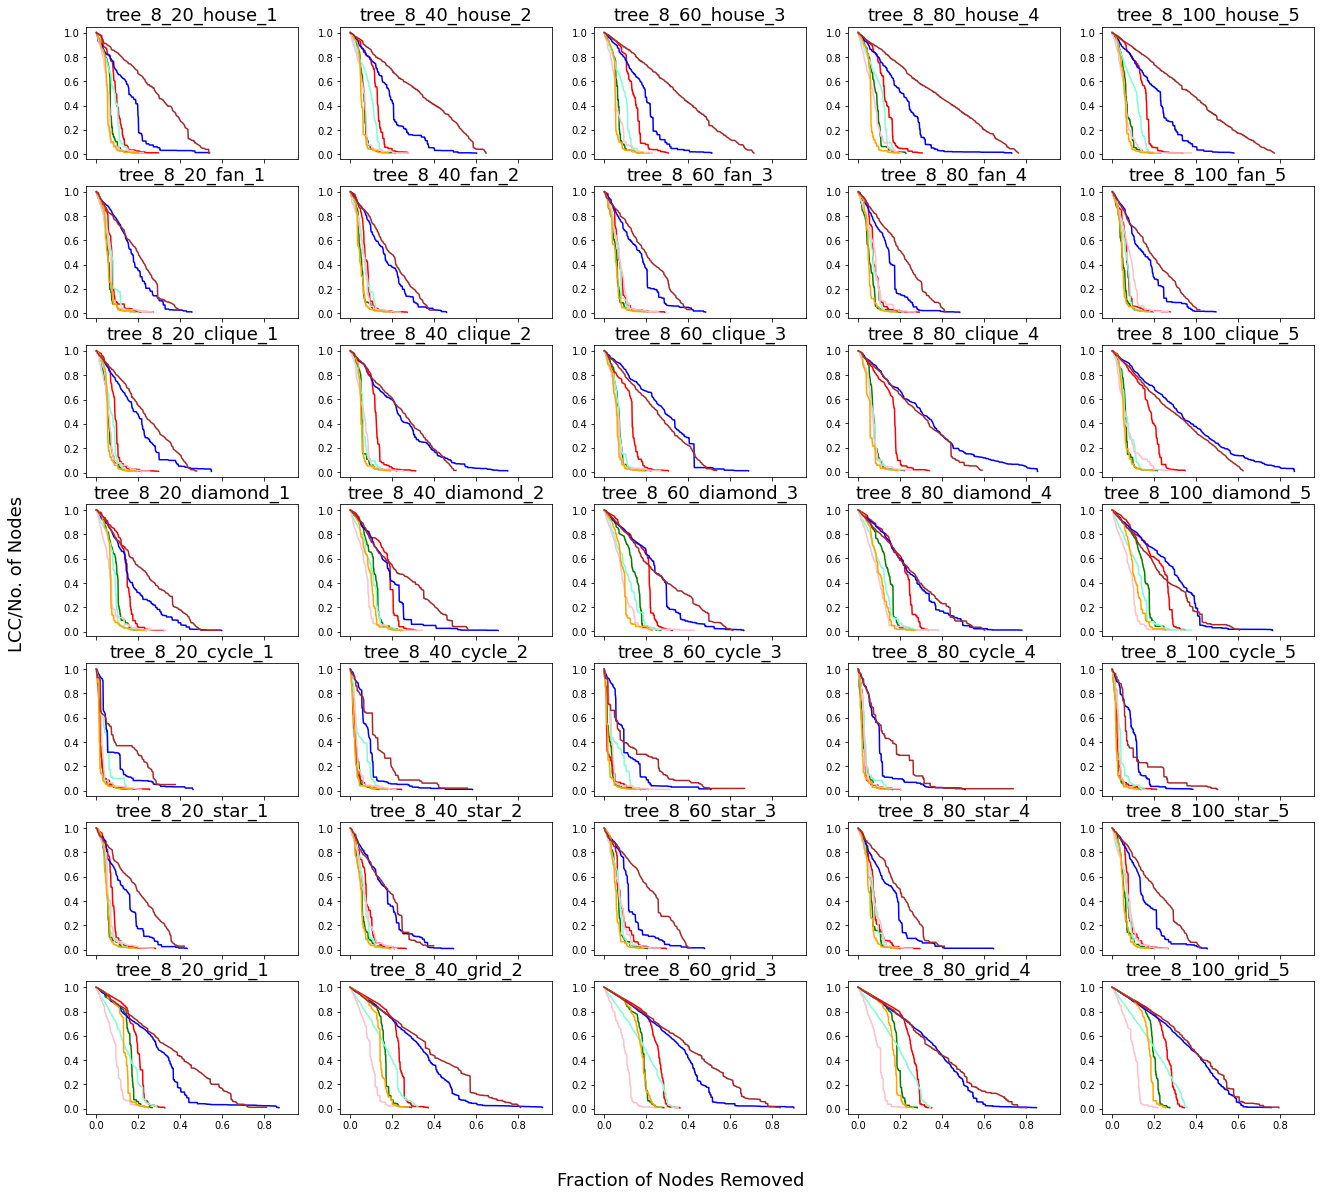

In [6]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
x, y = 7, 5
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Tree_Motifs",grid_plot,[x,y])


# Real World Network

corruption ,[32, 49, 50, 55, 56, 57, 58, 59, 61, 65, 66, 71, 22, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 14, 15, 27, 164, 165, 166, 16, 19, 167, 20, 168, 21, 169, 23, 29, 30, 48, 170, 31, 51, 33, 171, 200, 17, 35, 52, 172, 201, 202, 204, 205, 0, 1, 47, 173, 232, 207, 233, 211, 234, 53, 24, 133, 235, 54, 174, 206, 236, 183, 237, 175, 2, 3, 176, 4, 238, 177, 178, 60, 179, 18, 62, 127, 180, 73, 181, 182, 184, 69, 185, 63, 136, 39, 38, 137, 64, 186, 25, 138, 187, 67, 126, 139, 228, 26, 142, 70, 188, 28, 82, 129, 5, 268, 72, 34, 189, 156, 6, 36, 74, 240, 252, 260, 190, 77, 7, 191, 37, 287, 40, 75, 125, 8, 76, 212, 213, 152, 253, 261, 241, 210, 294, 78, 128, 155, 192, 248, 218, 214, 254, 262, 242, 250, 305, 41, 255, 79, 9, 83, 130, 151, 140, 158, 217, 221, 193, 243, 215, 263, 272, 283, 288, 297, 306, 42, 296, 277, 147, 10, 80, 141, 219, 85, 131, 153, 159, 194, 222, 216, 26

[101, 102, 68, 114, 123, 86, 87, 49, 71, 88, 100, 66, 38, 32, 31, 54, 33, 74, 55, 69, 34, 124, 39, 29, 93, 17, 47, 50, 52, 119, 28, 85, 91, 41, 40, 103, 125, 127, 84, 64, 21, 36, 0, 18, 22, 35, 56, 62, 37, 23, 126, 73, 53, 95, 30, 42, 26, 94, 27, 72, 48, 25, 122, 61, 90, 80, 20, 19, 8, 104, 57, 51, 89, 70, 6, 65, 15, 16, 83, 76, 99, 4, 105, 113, 24, 10, 9, 44, 67, 11, 14, 77, 43]
[56, 17, 84, 20, 54, 83, 95, 96, 87, 38, 41, 71, 42, 89, 50, 103, 127, 39, 91, 104, 52, 76, 51, 98, 90, 19, 94, 77, 100, 70, 121, 116, 102, 99, 72, 86, 22, 101, 75, 21, 30, 29, 78, 97, 61, 60, 59, 0, 73, 48, 74, 67, 88, 46, 18, 69, 79, 63, 31, 53, 27, 36, 92, 43, 58, 62, 32, 45, 28, 49, 82, 93, 80, 14, 81, 9, 11, 8, 57, 65, 16, 10, 85, 68, 66, 34, 40, 15]
[56, 21, 73, 74, 98, 96, 87, 38, 77, 75, 17, 116, 78, 103, 104, 71, 99, 95, 86, 83, 76, 72, 20, 84, 101, 100, 89, 22, 54, 102, 91, 97, 14, 10, 9, 11, 69, 70, 67, 121, 41, 29, 94, 19, 85, 90, 0, 127, 18, 46, 48, 88, 79, 81, 82, 80, 68, 16, 125, 42, 39, 50, 30,

[25, 172, 192, 197, 161, 97, 313, 307, 306, 319, 95, 286, 283, 291, 85, 259, 261, 199, 228, 200, 264, 196, 245, 265, 173, 262, 80, 191, 243, 174, 183, 175, 188, 58, 249, 202, 90, 229, 204, 282, 23, 117, 57, 126, 102, 116, 24, 107, 78, 27, 270, 273, 274, 275, 227, 226, 272, 26, 152, 56, 155, 131, 244, 246, 83, 99, 316, 7, 73, 136, 96, 203, 141, 28, 201, 298, 127, 233, 166, 171, 185, 133, 22, 67, 47, 84, 151, 231, 255, 186, 147, 89, 75, 100, 290, 134, 91, 214, 211, 79, 236, 238, 3, 16, 12, 20, 5, 13, 11, 17, 4, 21, 41, 19, 18, 15, 77, 179, 178, 128, 98, 142, 187, 132, 205, 176, 140, 49, 278, 130, 198, 193, 184, 120, 169, 170, 168, 121, 10, 9, 8, 93, 144, 225, 29, 48, 124, 115, 87, 88, 252, 216, 180, 288, 66, 160, 154, 159, 82, 125, 212, 70, 109, 68, 55, 101, 321, 322, 324, 276, 320, 323, 113, 112, 71, 122, 217, 139, 135, 206, 208, 210, 215, 218, 149, 221, 318, 222, 137, 138, 213, 294, 219, 285, 86, 81, 266, 251, 53, 300, 289, 52, 220, 234, 281, 235, 108, 105, 150, 118, 106, 74, 129, 76, 

[328, 330, 0, 36, 400, 151, 57, 512, 564, 259, 258, 257, 643, 28, 136, 189, 48, 402, 641, 608, 27, 629, 132, 581, 580, 329, 298, 40, 39, 299, 301, 734, 568, 344, 569, 552, 79, 567, 45, 450, 46, 513, 293, 292, 24, 247, 415, 423, 652, 413, 383, 382, 653, 750, 145, 263, 435, 436, 732, 196, 16, 255, 593, 219, 64, 342, 396, 34, 411, 264, 281, 496, 217, 230, 229, 280, 546, 218, 52, 233, 524, 68, 705, 69, 67, 42, 446, 572, 562, 560, 561, 731, 260, 635, 637, 591, 663, 615, 418, 76, 54, 56, 175, 115, 148, 442, 276, 461, 375, 434, 209, 482, 312, 134, 242, 240, 472, 407, 642, 437, 704, 162, 534, 533, 554, 44, 278, 77, 321, 666, 245, 314, 313, 315, 632, 316, 684, 389, 679, 81, 30, 211, 673, 210, 150, 465, 614, 304, 459, 305, 101, 578, 197, 124, 246, 35, 112, 5, 628, 665, 470, 694, 95, 347, 386, 362, 317, 355, 354, 626, 657, 656, 655, 164, 18, 19, 58, 537, 644, 147, 493, 215, 192, 692, 190, 307, 510, 701, 158, 159, 126, 627, 55, 234, 664, 588, 590, 707, 452, 451, 506, 163, 480, 376, 454, 377, 398, 

[696, 919, 690, 701, 665, 331, 752, 811, 806, 749, 657, 837, 648, 816, 757, 855, 776, 688, 719, 857, 900, 559, 631, 714, 630, 442, 27, 447, 355, 305, 240, 408, 405, 424, 443, 877, 356, 554, 558, 132, 409, 124, 293, 300, 303, 668, 301, 564, 823, 873, 555, 514, 7, 601, 604, 709, 633, 591, 592, 785, 858, 640, 646, 641, 647, 667, 533, 231, 202, 116, 121, 117, 436, 534, 152, 733, 284, 348, 286, 848, 138, 140, 432, 431, 382, 480, 457, 334, 201, 387, 624, 655, 607, 680, 832, 6, 660, 702, 556, 917, 692, 645, 446, 797, 850, 821, 92, 482, 507, 508, 204, 915, 264, 651, 761, 337, 652, 354, 371, 217, 357, 69, 218, 466, 798, 410, 95, 575, 713, 244, 693, 239, 227, 228, 463, 781, 169, 780, 39, 105, 112, 36, 35, 45, 336, 401, 675, 89, 144, 90, 107, 91, 106, 143, 808, 728, 880, 881, 822, 758, 52, 61, 60, 142, 72, 892, 841, 769, 481, 155, 789, 759, 704, 206, 64, 866, 26, 791, 21, 804, 605, 896, 603, 685, 606, 684, 404, 170, 654, 407, 629, 253, 290, 291, 271, 184, 306, 844, 824, 540, 225, 343, 365, 344, 3

[67, 51, 43, 112, 88, 134, 186, 311, 46, 45, 156, 109, 603, 33, 9, 108, 400, 23, 78, 894, 135, 101, 307, 81, 357, 434, 42, 147, 212, 72, 118, 305, 115, 26, 15, 851, 145, 310, 120, 217, 404, 190, 61, 396, 80, 364, 867, 85, 71, 50, 522, 178, 1, 893, 865, 251, 689, 25, 104, 314, 339, 211, 265, 962, 360, 19, 200, 691, 286, 48, 386, 332, 93, 205, 262, 318, 659, 257, 220, 133, 18, 488, 342, 782, 258, 543, 90, 173, 747, 65, 37, 55, 775, 390, 536, 63, 466, 5, 321, 970, 240, 710, 291, 720, 126, 60, 478, 635, 52, 7, 964, 124, 796, 345, 669, 167, 213, 49, 225, 805, 946, 620, 739, 957, 520, 106, 353, 870, 260, 407, 564, 600, 35, 347, 288, 62, 160, 298, 320, 459, 658, 223, 53, 57, 498, 388, 117, 628, 3, 66, 96, 614, 624, 605, 1140, 410, 229, 465, 737, 157, 325, 208, 779, 334, 139, 405, 1057, 665, 64, 207, 237, 254, 392, 597, 985, 986, 1008, 22, 1083, 24, 171, 511, 562, 303, 82, 1148, 854, 385, 98, 70, 963, 847, 349, 916, 506, 547, 8, 74, 219, 199, 279, 667, 755, 1167, 953, 455, 585, 464, 615, 815, 

facebook ,[288, 68, 70, 89, 216, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 246, 287, 289, 290, 291, 2230, 2628, 0, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 69, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 21

[2531, 2628, 290, 68, 246, 472, 496, 513, 529, 587, 597, 626, 641, 764, 289, 2629, 34, 288, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 473, 474

[720, 472, 496, 513, 529, 587, 597, 641, 713, 714, 715, 2254, 2258, 2272, 2307, 2346, 2354, 2363, 2371, 2384, 2386, 2428, 2432, 2250, 2253, 2256, 2288, 2297, 2301, 2304, 2309, 2311, 2336, 2377, 2385, 2413, 2420, 2423, 2425, 2426, 716, 719, 70, 246, 2646, 2649, 2651, 2644, 34, 216, 1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 41, 47, 48, 51, 53, 54, 56, 57, 58, 60, 62, 63, 64, 65, 67, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 86, 92, 93, 94, 96, 98, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 115, 116, 118, 120, 121, 122, 123, 124, 126, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 144, 145, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 161, 165, 166, 169, 170, 171, 172, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 188, 189, 190, 191, 192, 193, 194, 196, 197, 199, 200, 201, 202, 204, 205, 206, 207, 209, 210, 211, 212, 214, 215, 218, 219, 223, 

[290, 1566, 1572, 1649, 1727, 216, 1662, 1545, 1606, 1715, 1628, 1672, 1551, 1592, 1563, 1641, 1549, 89, 1720, 1602, 1604, 1666, 1567, 1658, 1591, 1721, 1553, 718, 717, 1708, 1706, 713, 715, 1680, 1631, 1718, 1679, 1723, 1596, 1548, 1689, 1681, 1599, 714, 1583, 1826, 2745, 2772, 2830, 2776, 2698, 2729, 2823, 2708, 1525, 2803, 2828, 2804, 2810, 2747, 2805, 2840, 2719, 2800, 2774, 2856, 2825, 2753, 2687, 2713, 287, 513, 626, 764, 597, 472, 722, 587, 721, 496, 529, 720, 641, 712, 0, 34, 70, 68, 289, 246, 291, 716, 719, 288]
powergrid ,[4639, 4625, 4656, 4621, 4624, 4620, 3468, 3138, 4668, 930, 929, 884, 3155, 3465, 3466, 3467, 4670, 191, 933, 939, 4669, 940, 2988, 936, 869, 4630, 3042, 2991, 3063, 3041, 3046, 3060, 2944, 1593, 4642, 3011, 2959, 3009, 3010, 2864, 460, 4675, 560, 3278, 2913, 2883, 2940, 4659, 912, 4665, 848, 2997, 756, 4680, 3667, 4683, 1773, 4664, 636, 442, 3059, 2022, 3036, 1166, 867, 286, 4189, 4636, 1258, 2957, 4673, 4674, 850, 4661, 3230, 3482, 690, 2987, 4648, 263, 31

[197, 3136, 2871, 658, 2790, 2427, 2740, 786, 611, 660, 2705, 1401, 575, 529, 1436, 3571, 4045, 3627, 2447, 3038, 2658, 2801, 63, 1337, 2903, 2760, 1638, 1025, 1099, 1446, 2704, 850, 2989, 3651, 2756, 4012, 657, 1643, 102, 4014, 3867, 144, 4361, 650, 2850, 34, 2794, 4314, 3234, 2874, 2707, 1631, 816, 1339, 2807, 696, 2718, 672, 1206, 2827, 2685, 53, 2072, 166, 2686, 489, 4551, 4343, 2952, 1252, 1431, 567, 964, 2660, 3059, 3179, 4532, 841, 2754, 3215, 2858, 1363, 1352, 1014, 930, 3517, 1322, 2872, 566, 2499, 155, 3262, 2657, 3325, 2600, 3327, 1498, 1501, 4536, 2787, 2746, 57, 4556, 3635, 1260, 2982, 4202, 2667, 3519, 1791, 3668, 276, 2123, 173, 2530, 3888, 711, 514, 1327, 1151, 2898, 4357, 3766, 2881, 2882, 1128, 1433, 3569, 4051, 4871, 3601, 4029, 513, 865, 814, 661, 3567, 3620, 4247, 670, 4388, 2724, 545, 1030, 3503, 4763, 654, 2699, 4516, 22, 4324, 3525, 2531, 3164, 4027, 2767, 70, 2785, 655, 4061, 1620, 385, 3848, 1816, 4020, 3818, 2659, 3637, 3691, 3173, 1075, 348, 2696, 671, 4782,

[3050, 3598, 934, 3488, 2643, 3808, 1737, 3122, 1408, 4574, 1616, 4475, 2166, 4545, 4208, 650, 4187, 4292, 1818, 2838, 1, 1742, 1091, 2704, 999, 668, 718, 1556, 2055, 2934, 2130, 2153, 4110, 3219, 59, 3894, 138, 3478, 541, 1449, 1079, 3658, 2923, 463, 2081, 1482, 2946, 2053, 177, 3995, 3965, 4214, 3754, 683, 647, 2137, 1954, 1670, 4117, 4173, 233, 559, 75, 4464, 1572, 4848, 3771, 2265, 1955, 1533, 4075, 4521, 2050, 20, 1655, 3310, 4916, 2772, 240, 3533, 3857, 3535, 1849, 1206, 1984, 15, 3260, 959, 3792, 1165, 4356, 149, 4235, 1092, 2641, 3254, 2275, 3702, 937, 3191, 54, 112, 446, 1922, 871, 3281, 4826, 3868, 1566, 419, 2066, 3249, 3815, 3023, 1591, 3708, 3119, 496, 3715, 998, 3253, 2957, 925, 497, 4795, 635, 3579, 3933, 116, 551, 3747, 3683, 4932, 1026, 1563, 1847, 3974, 2845, 1681, 1302, 2645, 2766, 2804, 1327, 2372, 4893, 879, 3549, 122, 1630, 2469, 2317, 4812, 785, 4711, 3734, 3054, 275, 401, 485, 2799, 1048, 1409, 2239, 2969, 3721, 1700, 2322, 1579, 4185, 705, 1328, 847, 4387, 3145

[3136, 3180, 3200, 3199, 3133, 3135, 3195, 2969, 3194, 3134, 3197, 3193, 4516, 4580, 4581, 4537, 4582, 2699, 3286, 2700, 2892, 3285, 2891, 4045, 4123, 4124, 4121, 4122, 4130, 4125, 4179, 4128, 4181, 4127, 4129, 660, 668, 680, 666, 667, 2705, 2709, 2721, 2722, 2703, 2717, 2720, 2716, 2802, 2714, 2719, 2427, 2435, 2432, 2436, 2431, 2437, 2441, 2439, 2433, 2434, 2430, 2489, 2438, 2576, 4524, 2746, 2764, 2747, 197, 762, 761, 1098, 286, 763, 284, 132, 529, 539, 537, 527, 528, 535, 2543, 538, 534, 4546, 4553, 657, 1903, 1905, 1785, 3186, 3161, 3160, 3503, 3495, 3629, 3623, 3624, 1327, 1334, 491, 1338, 4012, 4062, 4067, 4066, 4063, 4065, 4005, 4183, 4068, 4002, 4069, 241, 1226, 1225, 1436, 1469, 1479, 1440, 1471, 1470, 1480, 1638, 1647, 1645, 1646, 1644, 2187, 1651, 1650, 1648, 1649, 2189, 2185, 2188, 2136, 4525, 4557, 4584, 4583, 2740, 2744, 2741, 2750, 2749, 2774, 2753, 2743, 672, 3106, 3107, 674, 2730, 3038, 673, 2898, 3062, 3063, 3058, 3064, 1631, 1664, 1675, 1666, 1667, 1662, 1473, 1672,

/home/bhandk/AttackandDefend/utils/environment/envhelper.py:149: RuntimeWarning: ARPACK solver failed to converge (3001 iterations, 0/1 eigenvectors converged) at src/linalg/arpack.c:821
  eigen_centrality = np.array(g.eigenvector_centrality())


[45, 133, 58, 964, 66, 944, 121, 122, 59, 945, 60, 44, 946, 202, 308, 947, 466, 467, 468, 304, 301, 948, 285, 949, 286, 207, 240, 46, 253, 662, 206, 663, 254, 950, 645, 1133, 255, 602, 256, 951, 257, 258, 952, 604, 296, 242, 48, 54, 264, 354, 953, 85, 248, 266, 82, 538, 273, 451, 954, 1055, 267, 665, 1255, 1233, 607, 97, 247, 305, 1223, 170, 355, 96, 671, 865, 608, 646, 249, 557, 452, 955, 1056, 1224, 1283, 161, 1248, 609, 99, 93, 95, 462, 94, 268, 356, 251, 610, 105, 517, 276, 303, 603, 535, 316, 724, 217, 111, 88, 761, 453, 809, 956, 1057, 1225, 1246, 1284, 649, 432, 252, 169, 327, 725, 41, 277, 433, 243, 832, 153, 1126, 718, 454, 762, 810, 957, 1058, 1226, 1247, 1285, 89, 1202, 537, 1339, 358, 434, 112, 130, 691, 634, 971, 353, 551, 635, 1129, 870, 1197, 175, 341, 211, 648, 310, 244, 1262, 18, 118, 143, 455, 763, 811, 958, 1033, 1059, 1162, 1227, 1249, 51, 612, 740, 1134, 213, 232, 484, 49, 606, 611, 582, 734, 1286, 680, 441, 1070, 879, 692, 259, 340, 19, 75, 119, 673, 624, 705, 777

[43, 894, 892, 893, 910, 909, 908, 907, 905, 904, 903, 906, 902, 901, 44, 106, 204, 45, 172, 747, 243, 535, 40, 143, 609, 147, 1183, 120, 184, 748, 466, 208, 766, 84, 475, 512, 298, 1036, 170, 81, 11, 51, 185, 173, 53, 423, 54, 328, 541, 410, 497, 376, 531, 47, 86, 174, 426, 241, 48, 540, 459, 1210, 110, 60, 135, 1339, 399, 1098, 556, 307, 1100, 101, 588, 268, 211, 209, 446, 395, 236, 234, 305, 1026, 324, 315, 207, 326, 707, 226, 327, 411, 123, 197, 100, 381, 203, 228, 525, 523, 122, 424, 196, 370, 346, 124, 809, 485, 488, 486, 1234, 1236, 1237, 1238, 736, 483, 416, 117, 1279, 1218, 1217, 1024, 1025, 1027, 1028, 1216, 1272, 1215, 58, 59, 1205, 1363, 792, 511, 332, 1058, 608, 271, 454, 1416, 1418, 551, 791, 796, 532, 1171, 623, 590, 80, 82, 922, 632, 631, 987, 1251, 129, 285, 284, 923, 1235, 17, 154, 292, 534, 149, 580, 740, 276, 278, 343, 583, 530, 536, 293, 757, 1326, 1325, 1324, 477, 476, 1239, 458, 478, 457, 617, 449, 1294, 1293, 441, 440, 439, 438, 918, 450, 919, 921, 945, 946, 599

[106, 43, 44, 328, 892, 893, 45, 184, 894, 410, 891, 185, 895, 531, 143, 47, 120, 896, 1098, 897, 170, 81, 898, 1095, 84, 243, 899, 485, 48, 53, 426, 796, 1100, 101, 900, 486, 298, 532, 1210, 425, 1235, 147, 204, 315, 901, 1021, 488, 173, 326, 123, 316, 902, 1022, 1211, 1272, 86, 475, 144, 292, 122, 609, 208, 124, 149, 317, 661, 716, 903, 1023, 1212, 1233, 1273, 174, 535, 197, 748, 424, 203, 110, 590, 345, 951, 1328, 502, 1183, 318, 662, 717, 904, 1024, 1213, 1234, 1274, 922, 512, 565, 423, 800, 148, 530, 17, 129, 466, 1251, 987, 1171, 623, 60, 370, 395, 1096, 556, 291, 809, 1036, 91, 157, 319, 663, 718, 905, 999, 1025, 1140, 1214, 1236, 1275, 416, 54, 503, 483, 541, 580, 209, 677, 446, 801, 32, 80, 150, 534, 1416, 145, 332, 511, 271, 454, 608, 1058, 11, 736, 40, 191, 307, 459, 4, 593, 92, 158, 172, 268, 320, 559, 388, 621, 664, 719, 729, 906, 1000, 1026, 1062, 1077, 1141, 1165, 1425, 1182, 1215, 1237, 1267, 1276, 1384, 791, 226, 100, 381, 376, 497, 1097, 241, 747, 766, 196, 845, 631, 

[43, 77, 71, 44, 79, 78, 85, 70, 89, 106, 214, 219, 216, 210, 220, 218, 892, 531, 894, 1396, 143, 410, 120, 308, 898, 903, 1098, 45, 64, 63, 204, 520, 519, 516, 517, 515, 521, 909, 47, 591, 592, 243, 253, 254, 252, 897, 185, 333, 899, 1100, 1108, 1109, 53, 128, 52, 127, 908, 328, 783, 420, 785, 784, 782, 336, 170, 182, 175, 181, 1095, 81, 916, 917, 292, 302, 900, 425, 1235, 486, 609, 875, 877, 876, 880, 879, 878, 326, 558, 891, 488, 84, 215, 147, 637, 638, 110, 380, 387, 386, 426, 428, 433, 434, 427, 48, 50, 321, 901, 1028, 1216, 101, 112, 99, 535, 1120, 1119, 172, 189, 171, 188, 187, 186, 485, 492, 895, 315, 1024, 1275, 1212, 241, 951, 475, 1172, 1328, 922, 927, 532, 144, 146, 86, 88, 87, 149, 152, 1023, 322, 1273, 1217, 809, 810, 665, 1241, 503, 501, 716, 298, 247, 335, 780, 325, 781, 183, 334, 123, 138, 137, 173, 192, 747, 750, 749, 752, 751, 203, 286, 910, 129, 60, 654, 653, 736, 1160, 1159, 423, 618, 619, 174, 177, 246, 176, 244, 245, 248, 242, 122, 421, 414, 197, 199, 198, 1251, 

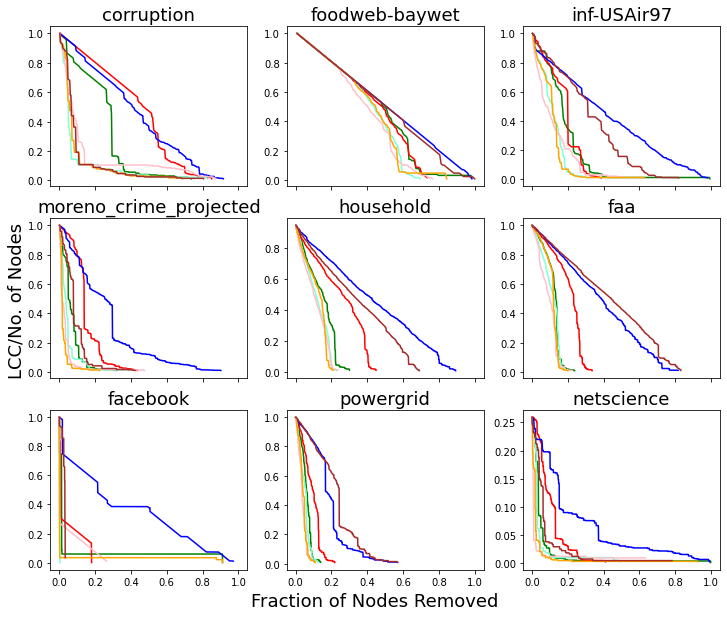

In [7]:
BA =  349000
MIX = 111500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]
file_list = ["corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'household','faa','facebook','powergrid','netscience']
graph_path =  "./Dataset/Real/"
x, y = 3, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
#[print(i,file_list[i],grid_plot[i][0],grid_plot[i][1]) for i in range(x*y)]
visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Real",grid_plot,[x,y])


## Cancer Gene

COAD ,[50, 78, 275, 276, 278, 279, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 318, 319, 1, 2, 4, 5, 7, 8, 232, 280, 321, 322, 326, 327, 328, 329, 74, 330, 331, 333, 334, 335, 336, 337, 338, 341, 342, 345, 346, 347, 349, 332, 350, 352, 353, 354, 355, 348, 356, 357, 358, 339, 360, 361, 362, 365, 366, 368, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 382, 384, 385, 386, 387, 388, 6, 324, 364, 370, 390, 391, 392, 394, 395, 398, 399, 400, 401, 402, 403, 405, 406, 407, 409, 410, 411, 414, 416, 417, 418, 419, 420, 421, 422, 424, 427, 425, 428, 429, 431, 432, 434, 435, 436, 437, 438, 439, 441, 442, 18, 443, 445, 446, 447, 448, 450, 451, 452, 455, 457, 3, 13, 219, 383, 440, 444, 449, 453, 461, 462, 463, 466, 470, 323, 479, 482, 483, 487, 415, 488, 490, 38, 476, 480, 491, 497, 500, 504, 513, 523, 528, 536, 537, 541, 543, 545, 546, 547, 551, 554, 562, 566, 819, 

[83, 2378, 112, 2, 69, 6, 355, 621, 31, 1773, 1177, 85, 3, 26, 180, 124, 351, 71, 4, 436, 125, 620, 1092, 177, 5, 1, 633, 502, 593, 608, 1131, 67, 376, 1674, 155, 1263, 586, 2117, 713, 880, 640, 86, 42, 123, 179, 244, 253, 189, 1027, 575, 507, 16, 905, 499, 233, 1102, 479, 720, 1116, 198, 613, 81, 1012, 421, 600, 645, 1016, 999, 928, 256, 229, 1009, 437, 1095, 504, 1854, 157, 1107, 68, 1100, 3664, 1014, 397, 1098, 740, 143, 665, 366, 1125, 632, 238, 584, 27, 1274, 202, 644, 1130, 1681, 448, 710, 2589, 435, 1678, 1099, 1435, 567, 362, 138, 3757, 2224, 485, 883, 1913, 440, 1959, 618, 1775, 594, 478, 818, 332, 706, 500, 1524, 510, 308, 505, 1015, 592, 1679, 4357, 119, 674, 393, 161, 291, 158, 183, 2548, 128, 114, 595, 1803, 1469, 855, 599, 887, 560, 582, 64, 220, 637, 322, 1104, 612, 1410, 1013, 588, 361, 372, 589, 2203, 340, 140, 11, 2111, 65, 339, 1174, 865, 732, 3390, 484, 587, 182, 1818, 148, 121, 207, 402, 254, 411, 118, 167, 271, 801, 77, 247, 1164, 1556, 1028, 625, 139, 359, 607, 7

FileNotFoundError: ./ReI_CI/COAD.txt not found.

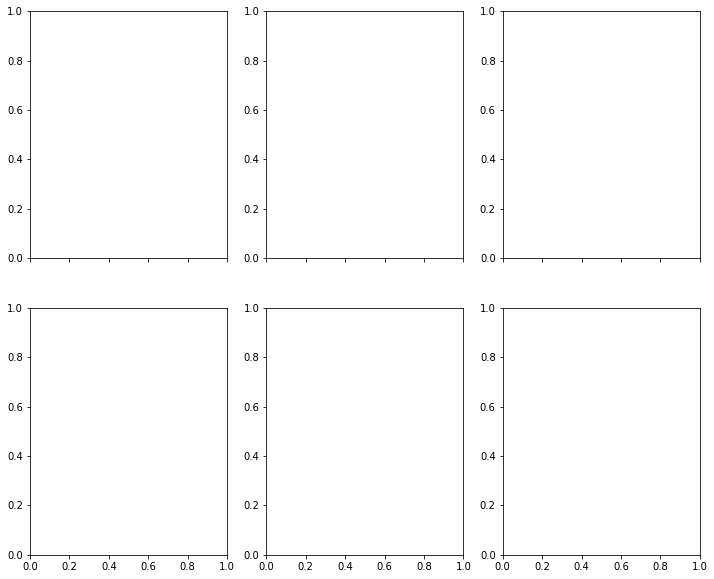

In [8]:
BA =  106500
MIX =  440000 
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","PRAD","UCEC"]
x, y = 2, 3
grid_plot = [[i,j] for i in range(x) for j in range(y)]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]],"Cancer_Gene",grid_plot,[x,y])